<a href="https://colab.research.google.com/github/mavivi95/overfittingLipschitzBound/blob/main/validationMethodLBExperimentoAPaperModelo4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
print(tf.__version__) # Verificar 2.9.0

2.18.0


In [ ]:
# Manejo de datos
import numpy as np
import pandas as pd

# Visualización
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

# TensorFlow y Keras

from tensorflow.keras.utils import plot_model
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Conv2D, Add, Flatten, Dense, MaxPooling2D, Input, Add, Dropout
from tensorflow.keras import regularizers as l
from tensorflow.keras.regularizers import l2

# Métricas y evaluación
from sklearn import metrics
from sklearn.model_selection import KFold, ShuffleSplit, GridSearchCV

# Funciones matemáticas
from numpy.linalg import norm
from scipy import interpolate

# Otros
import os
import time

import sklearn

In [ ]:
print(os.getcwd())

/content


In [ ]:
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']

In [ ]:
from tensorflow import keras
def load_data():
  mnist = keras.datasets.mnist
  (X_train, y_train), (X_test, y_test) = mnist.load_data()
  X_train, X_test = X_train / 255.0, X_test / 255.0
  X_train = X_train.reshape(len(y_train),784)
  X_test  = X_test.reshape(len(y_test),784)

  y_train_onehot = keras.utils.to_categorical(y_train)
  y_test_onehot =  keras.utils.to_categorical(y_test)

  print(f'Conjunto de datos cargados')
  print(f'Tamaño imágenes de entrenamiento {X_train[:10000].shape}')
  print(f'Tamaño imágenes de test {X_test.shape}')
  print(f'Datos por cada etiqueta en X train {np.bincount(y_train[:10000])}')
  return X_train[:10000], X_test, y_train_onehot[:10000], y_test_onehot, y_train[:10000], y_test

In [ ]:
X_train, X_test, y_train_onehot, y_test_onehot, y_train, y_test = load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Conjunto de datos cargados
Tamaño imágenes de entrenamiento (10000, 784)
Tamaño imágenes de test (10000, 784)
Datos por cada etiqueta en X train [1001 1127  991 1032  980  863 1014 1070  944  978]


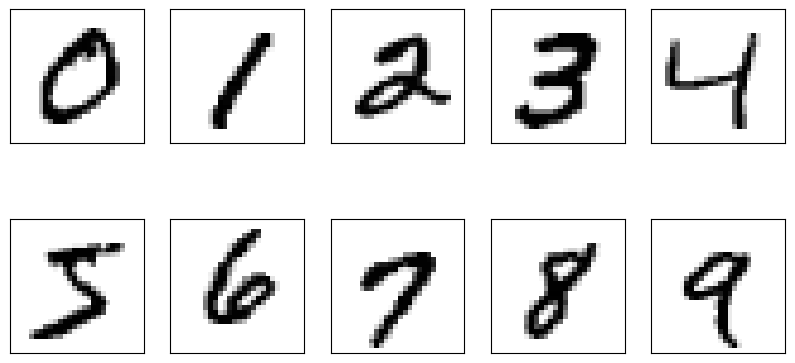

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True, figsize=(10, 5))

ax = ax.flatten()
for i in range(10):
    img = X_train[y_train == i][0].reshape(28, 28)
    ax[i].imshow(img, cmap='gist_yarg')

ax[0].set_xticks([])
ax[0].set_yticks([])

plt.show()


## Modelo con $n$ saltos residuales convolucionales

In [ ]:
def skip_conection(dense_input, n, regular_l, dropout_rate):
  if n >= 2:
    resDense = Dropout(dropout_rate)(Dense(50, activation ='relu', kernel_regularizer=regular_l)(dense_input))
    return skip_conection(Add()([dense_input, resDense]), n-1, regular_l, dropout_rate)
  resDenseo = Dropout(dropout_rate)(Dense(50, activation ='relu', kernel_regularizer=regular_l)(dense_input))
  return Add()([dense_input, resDenseo])

# Función para cargar el modelo
def load_model(n, regular_l, dropout_rate):
    """
    Construye un modelo con capas convolucionales, conexiones residuales, dropout y regularización.

    Args:
        n: Número de bloques residuales.
        filters: Número de filtros en las capas convolucionales.
        kernel_size: Tamaño del kernel.
        regular_l: Regularización L1, L2 o L1_L2.
        dropout_rate: Tasa de dropout.

    Returns:
        Modelo compilado de TensorFlow.
    """
    tf.keras.backend.clear_session()

    # Entrada para imágenes de MNIST
    inputs  = Input(shape=(784,))

    dense1  = Dense(50, activation  ='relu', kernel_regularizer=regular_l)(inputs)

    # Capas residuales
    skip_final = skip_conection(dense1, n, regular_l, dropout_rate)

    # Pooling y capa densa final
    outputs = Dense(10, activation='softmax', kernel_regularizer=regular_l)(skip_final)

    return Model(inputs=inputs, outputs=outputs, name='CustomModel')


## Modelo general

In [ ]:
n = 4
regularization = l.l2(0)  # Regularización L2
dropout = 0 # Tasa de dropout
model = load_model(n=4,
                   regular_l=regularization,
                   dropout_rate=dropout)
model.summary()

Model: "CustomModel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 784)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 50)             │         39,250 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 50)             │          2,550 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 50)             │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 50)             │              0 │ dense[0][0],           │
│                           │                        │                │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 50)             │          2,550 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 50)             │              0 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 50)             │              0 │ add[0][0],             │
│                           │                        │                │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 50)             │          2,550 │ add_1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 50)             │              0 │ dense_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_2 (Add)               │ (None, 50)             │              0 │ add_1[0][0],           │
│                           │                        │                │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 50)             │          2,550 │ add_2[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 50)             │              0 │ dense_4[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_3 (Add)               │ (None, 50)             │              0 │ add_2[0][0],           │
│                           │                        │                │ dropout_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 10)             │            510 │ add_3[0][0]            │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 49,960 (195.16 KB)

 Trainable params: 49,960 (195.16 KB)

 Non-trainable params: 0 (0.00 B)

# Funciones regularización LBA

In [ ]:
def spectral_norm_dense(layer, power_iterations=10):
    kernel = layer.kernel  # Pesos de la capa densa

    u = tf.random.normal([kernel.shape[-1], 1])  # Vector inicial

    for _ in range(power_iterations):  # Menos iteraciones para acelerar
        v = tf.linalg.matmul(kernel, u, transpose_a=False)
        v /= tf.norm(v) + 1e-10  # Evitar divisiones por cero
        u = tf.linalg.matmul(kernel, v, transpose_a=True)
        u /= tf.norm(u) + 1e-10

    sigma = tf.linalg.matmul(tf.linalg.matmul(u, kernel, transpose_a=True, transpose_b=True), v)
    return sigma.numpy()[0, 0]

In [ ]:
# Función optimizada de entrenamiento
def train_model_with_dynamic_reg(model, X_train, y_train, X_val, y_val,
                                 epochs=30, reg_update_freq=5, regularization_flag=True):

    optimizer = tf.keras.optimizers.Adam(0.001)
    loss_fn = tf.keras.losses.CategoricalCrossentropy()

    train_acc_metric = tf.keras.metrics.CategoricalAccuracy()
    val_acc_metric = tf.keras.metrics.CategoricalAccuracy()

    history = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': []}

    lipschitz_factor = None  # Factor inicializado en None

    for epoch in range(epochs):
        print(f"\nÉpoca {epoch+1}/{epochs}")

        if regularization_flag and (epoch % reg_update_freq == 0):  # Calcular solo cada `reg_update_freq` épocas
          dense_layers = [l for l in model.layers if isinstance(l, Dense)][1:-1]
          if dense_layers:
              selected_layer = np.random.choice(dense_layers)
              lipschitz_factor = spectral_norm_dense(selected_layer)
              #print(f"Norma espectral calculada en la capa {selected_layer.name}: {lipschitz_factor:.4f}")


        n_batch = 400
        # Entrenamiento por lotes
        for step in range(len(X_train) // n_batch):  # Asumiendo batch_size=32
            batch_X = X_train[step * n_batch:(step + 1) * n_batch]
            batch_y = y_train[step * n_batch:(step + 1) * n_batch]



            with tf.GradientTape() as tape:
                logits = model(batch_X, training=True)
                loss = loss_fn(batch_y, logits)

                if regularization_flag and lipschitz_factor is not None:
                    reg_loss = lipschitz_factor * tf.nn.l2_loss(selected_layer.kernel)
                    total_loss = loss + reg_loss
                else:
                    total_loss = loss

            gradients = tape.gradient(total_loss, model.trainable_weights)
            optimizer.apply_gradients(zip(gradients, model.trainable_weights))

            train_acc_metric.update_state(batch_y, logits)

        # Validación
        val_logits = model.predict(X_val, verbose=0)
        val_loss = loss_fn(y_val, val_logits)
        val_acc_metric.update_state(y_val, val_logits)

        # Guardar métricas
        history['loss'].append(total_loss.numpy())
        history['accuracy'].append(train_acc_metric.result().numpy())
        history['val_loss'].append(val_loss.numpy())
        history['val_accuracy'].append(val_acc_metric.result().numpy())

        # Imprimir métricas
        if regularization_flag and lipschitz_factor is not None:
            print(f"Loss: {total_loss:.4f} (Reg: {reg_loss:.4f}), Val Loss: {val_loss:.4f}")
        else:
            print(f"Loss: {total_loss:.4f}, Val Loss: {val_loss:.4f}")
        print(f"Acc: {train_acc_metric.result().numpy()}, Val Acc: {val_acc_metric.result().numpy()}")



    return history, model

# Modelo sin regularización

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
epochs = 30
acc_train = []
acc_val = []
acc_test = []
histories = []
times = []

time_start_total = time.time()
for i, (train_index, test_index) in enumerate(kf.split(X_train)):
    print(f'\nEntrenando pliegue {i+1}')
    time_start = time.time()
    # Crear modelo nuevo por pliegue

    n_blocks = 4  # Número de bloques residuales convolucionales
    regularization = l.l2(0)  # Regularización L2
    dropout = 0 # Tasa de desconeción

    model = load_model(n=n_blocks,
                       regular_l=regularization,
                       dropout_rate=dropout)


    # Datos del fold
    X_train_fold, X_val_fold = X_train[train_index], X_train[test_index]
    y_train_fold, y_val_fold = y_train_onehot[train_index], y_train_onehot[test_index]

    # Entrenamiento con regularización dinámica
    history, model = train_model_with_dynamic_reg(
        model, X_train_fold, y_train_fold, X_val_fold, y_val_fold,
        epochs=epochs, reg_update_freq=1, regularization_flag = False
    )


    histories.append(history)
    # Guardar métricas y historial

    acc_final_train = history['accuracy'][-1]
    acc_final_val = history['val_accuracy'][-1]

    test_predictions = model.predict(X_test, verbose=0)
    acc_final_test = sklearn.metrics.accuracy_score(y_true=y_test, y_pred=np.argmax(test_predictions, axis=-1))


    acc_train.append(acc_final_train)
    acc_val.append(acc_final_val)
    acc_test.append(acc_final_test)

    time_end = time.time()
    times.append(time_end -  time_start)
    print(f'Pliegue {i+1} - Accuracy: {acc_final_train:.4f} - Val Accuracy: {acc_final_val:.4f} - Test Accuracy:{acc_final_test:.4f} - Time {time_end -  time_start}')

time_end_total = time.time()
# Resultados finales
print(f'\nFinal Results --------------------------------------------')
print(f'\nMean Train Accuracy: {np.mean(acc_train):.4f} ± {np.std(acc_train):.4f}')
print(f'Mean Val Accuracy: {np.mean(acc_val):.4f} ± {np.std(acc_val):.4f}')
print(f'Mean Test Accuracy: {np.mean(acc_test):.4f} ± {np.std(acc_test):.4f}')
print(f'Mean Times per fold: {np.mean(times):.2f}± {np.std(times):.2f}')
print(f'Total Time:{time_end_total-time_start_total:.0f}')
print(f'-------------------------------------------------------------')


Entrenando pliegue 1

Época 1/30
Loss: 1.3320, Val Loss: 1.3073
Acc: 0.37674999237060547, Val Acc: 0.6345000267028809

Época 2/30
Loss: 0.5338, Val Loss: 0.5515
Acc: 0.5589374899864197, Val Acc: 0.7422500252723694

Época 3/30
Loss: 0.3712, Val Loss: 0.3771
Acc: 0.6613333225250244, Val Acc: 0.7935000061988831

Época 4/30
Loss: 0.3018, Val Loss: 0.3192
Acc: 0.7208124995231628, Val Acc: 0.8243749737739563

Época 5/30
Loss: 0.2433, Val Loss: 0.2859
Acc: 0.760574996471405, Val Acc: 0.8443999886512756

Época 6/30
Loss: 0.2087, Val Loss: 0.2671
Acc: 0.788937509059906, Val Acc: 0.8585000038146973

Época 7/30
Loss: 0.1805, Val Loss: 0.2527
Acc: 0.810535728931427, Val Acc: 0.8689285516738892

Época 8/30
Loss: 0.1542, Val Loss: 0.2438
Acc: 0.8274999856948853, Val Acc: 0.8766875267028809

Época 9/30
Loss: 0.1363, Val Loss: 0.2345
Acc: 0.8412638902664185, Val Acc: 0.883055567741394

Época 10/30
Loss: 0.1167, Val Loss: 0.2271
Acc: 0.8527625203132629, Val Acc: 0.888450026512146

Época 11/30
Loss: 0.

In [ ]:
# Inicializar listas para almacenar las métricas por época
epochs = len(histories[0]['loss'])
train_loss_all = np.zeros((len(histories), epochs))
val_loss_all = np.zeros((len(histories), epochs))
train_acc_all = np.zeros((len(histories), epochs))
val_acc_all = np.zeros((len(histories), epochs))

# Extraer métricas de cada pliegue
for i, history in enumerate(histories):
    train_loss_all[i, :] = history['loss']
    val_loss_all[i, :] = history['val_loss']
    train_acc_all[i, :] = history['accuracy']
    val_acc_all[i, :] = history['val_accuracy']

# Promedio y desviación estándar
train_loss_mean = np.mean(train_loss_all, axis=0)
train_loss_std = np.std(train_loss_all, axis=0)
val_loss_mean = np.mean(val_loss_all, axis=0)
val_loss_std = np.std(val_loss_all, axis=0)

train_acc_mean = np.mean(train_acc_all, axis=0)
train_acc_std = np.std(train_acc_all, axis=0)
val_acc_mean = np.mean(val_acc_all, axis=0)
val_acc_std = np.std(val_acc_all, axis=0)

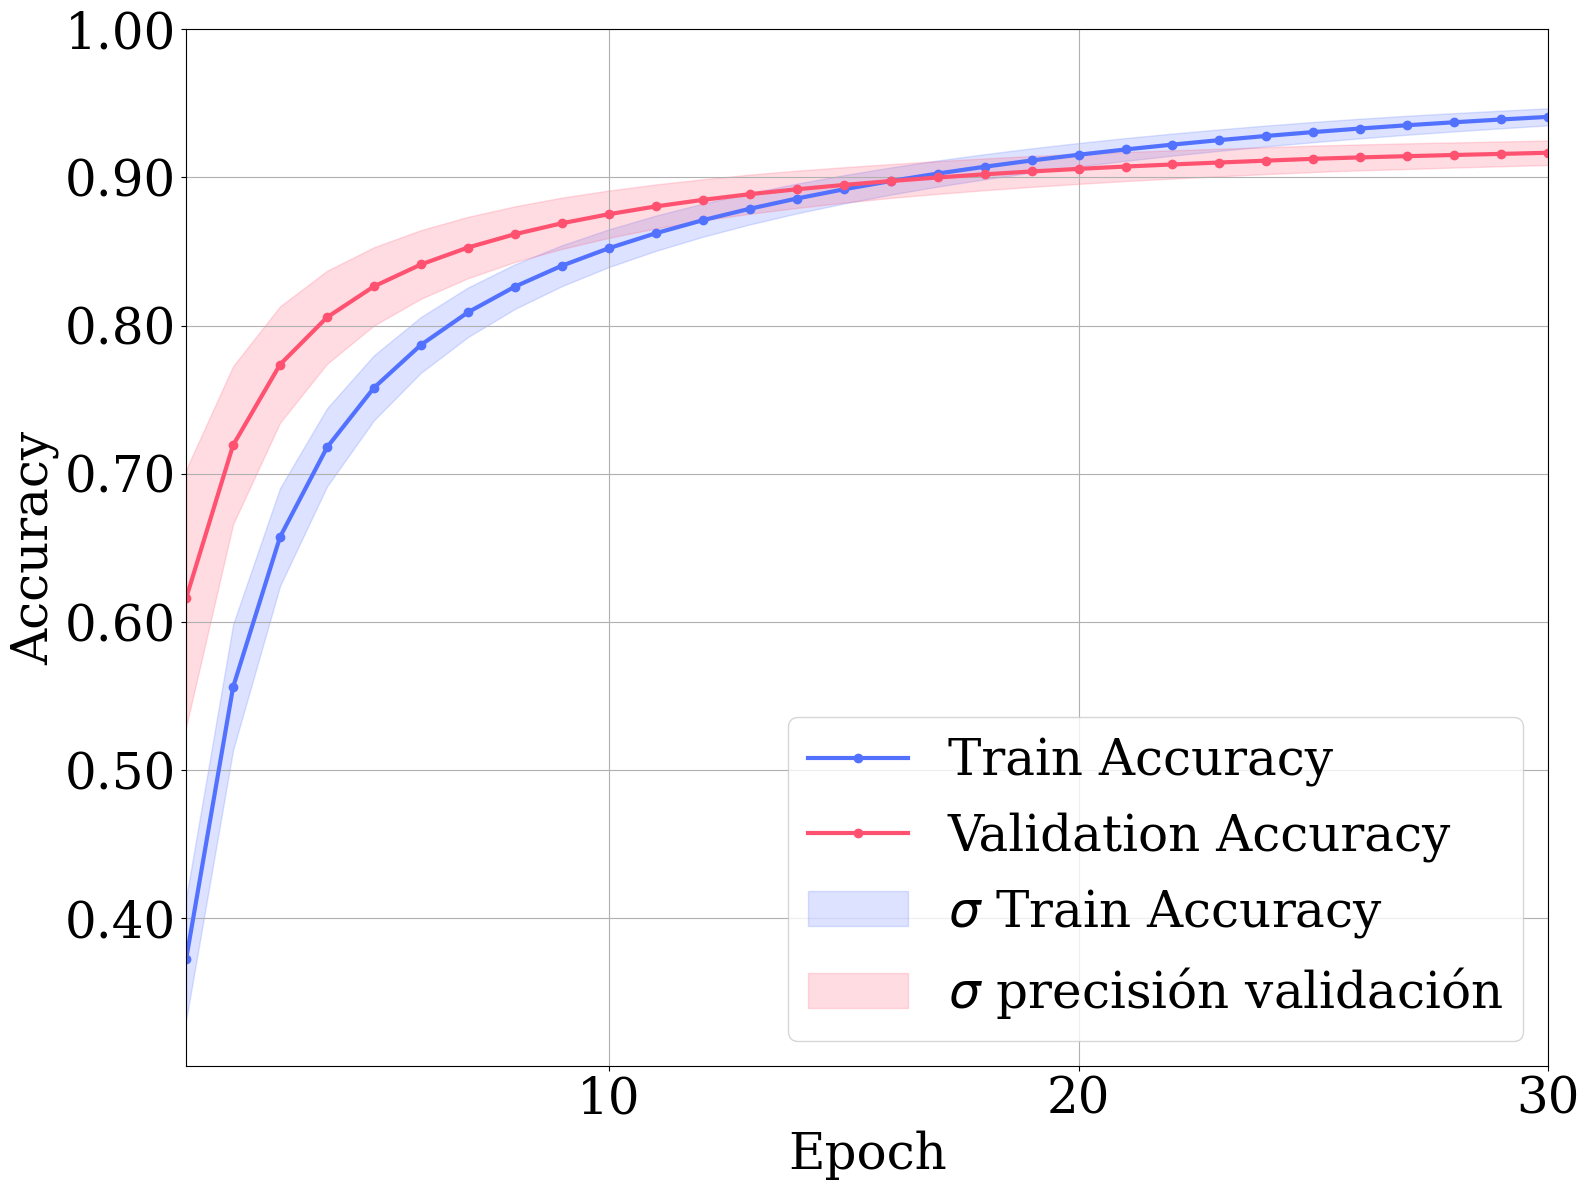

In [ ]:
# Gráfica de precisión

fig = plt.figure(figsize=(16, 12))
ax = plt.gca()
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.plot(range(1, epochs+1), train_acc_mean, '#5271ff', linestyle = "-", marker = "o",
          label='Train Accuracy', lw = 3)
plt.plot(range(1, epochs+1), val_acc_mean,  '#ff5271',
          label='Validation Accuracy', linestyle = '-', marker = 'o', lw = 3)
plt.fill_between(range(1, epochs+1),
                 train_acc_mean - train_acc_std,
                 train_acc_mean + train_acc_std,
                 label = r'$\sigma$ Train Accuracy',
                 alpha=0.2, color = '#5271ff')

plt.fill_between(range(1, epochs+1),
                 val_acc_mean - val_acc_std,
                 val_acc_mean + val_acc_std,
                 label = r'$\sigma$ precisión validación',
                 alpha=0.2, color = '#ff5271')
plt.xlabel('Epoch',fontsize=36)
plt.ylabel(r'Accuracy',fontsize=36)
plt.xlim([1, epochs])
plt.ylim(top=1)
plt.grid()
plt.legend(fontsize=36,loc = 'lower right')
plt.xticks(np.arange(10, epochs+1, step=10), fontsize=36)
plt.yticks(fontsize=36)
plt.tight_layout()
nameFile = 'presicionModelo4CapasSinRegularizacion' +'.pdf'
plt.tight_layout()
plt.savefig(nameFile)

# Modelo regularización LBA

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
epochs = 30
acc_train = []
acc_val = []
acc_test = []
histories = []
times = []

time_start_total = time.time()
for i, (train_index, test_index) in enumerate(kf.split(X_train)):
    print(f'\nEntrenando pliegue {i+1}')
    time_start = time.time()
    # Crear modelo nuevo por pliegue

    n_blocks = 4  # Número de bloques residuales convolucionales
    regularization = l.l2(0)  # Regularización L2
    dropout = 0 # Tasa de desconeción

    model = load_model(n=n_blocks,
                       regular_l=regularization,
                       dropout_rate=dropout)


    # Datos del fold
    X_train_fold, X_val_fold = X_train[train_index], X_train[test_index]
    y_train_fold, y_val_fold = y_train_onehot[train_index], y_train_onehot[test_index]

    # Entrenamiento con regularización dinámica
    history, model = train_model_with_dynamic_reg(
        model, X_train_fold, y_train_fold, X_val_fold, y_val_fold,
        epochs=epochs, reg_update_freq=1, regularization_flag = True
    )


    histories.append(history)
    # Guardar métricas y historial

    acc_final_train = history['accuracy'][-1]
    acc_final_val = history['val_accuracy'][-1]

    test_predictions = model.predict(X_test, verbose=0)
    acc_final_test = sklearn.metrics.accuracy_score(y_true=y_test, y_pred=np.argmax(test_predictions, axis=-1))


    acc_train.append(acc_final_train)
    acc_val.append(acc_final_val)
    acc_test.append(acc_final_test)

    time_end = time.time()
    times.append(time_end -  time_start)
    print(f'Pliegue {i+1} - Accuracy: {acc_final_train:.4f} - Val Accuracy: {acc_final_val:.4f} - Test Accuracy:{acc_final_test:.4f} - Time {time_end -  time_start}')

time_end_total = time.time()
# Resultados finales
print(f'\nFinal Results --------------------------------------------')
print(f'\nMean Train Accuracy: {np.mean(acc_train):.4f} ± {np.std(acc_train):.4f}')
print(f'Mean Val Accuracy: {np.mean(acc_val):.4f} ± {np.std(acc_val):.4f}')
print(f'Mean Test Accuracy: {np.mean(acc_test):.4f} ± {np.std(acc_test):.4f}')
print(f'Mean Times per fold: {np.mean(times):.2f}± {np.std(times):.2f}')
print(f'Total Time:{time_end_total-time_start_total:.0f}')
print(f'-------------------------------------------------------------')


Entrenando pliegue 1

Época 1/30
Loss: 39.7757 (Reg: 38.5662), Val Loss: 1.1783
Acc: 0.37950000166893005, Val Acc: 0.6504999995231628

Época 2/30
Loss: 36.8178 (Reg: 36.2412), Val Loss: 0.5924
Acc: 0.5668749809265137, Val Acc: 0.7465000152587891

Época 3/30
Loss: 34.1754 (Reg: 33.7858), Val Loss: 0.4417
Acc: 0.6636666655540466, Val Acc: 0.7914999723434448

Época 4/30
Loss: 20.1191 (Reg: 19.7996), Val Loss: 0.3771
Acc: 0.7199062705039978, Val Acc: 0.8168749809265137

Época 5/30
Loss: 19.9513 (Reg: 19.6753), Val Loss: 0.3363
Acc: 0.7575500011444092, Val Acc: 0.8343999981880188

Época 6/30
Loss: 30.0637 (Reg: 29.8004), Val Loss: 0.3196
Acc: 0.7843124866485596, Val Acc: 0.847083330154419

Época 7/30
Loss: 12.3892 (Reg: 12.1416), Val Loss: 0.2991
Acc: 0.8043749928474426, Val Acc: 0.8571428656578064

Época 8/30
Loss: 8.1004 (Reg: 7.8746), Val Loss: 0.2817
Acc: 0.8199999928474426, Val Acc: 0.8651250004768372

Época 9/30
Loss: 5.3868 (Reg: 5.1764), Val Loss: 0.2669
Acc: 0.8326944708824158, Va

In [ ]:
# Inicializar listas para almacenar las métricas por época
epochs = len(histories[0]['loss'])
train_loss_all = np.zeros((len(histories), epochs))
val_loss_all = np.zeros((len(histories), epochs))
train_acc_all = np.zeros((len(histories), epochs))
val_acc_all = np.zeros((len(histories), epochs))

# Extraer métricas de cada pliegue
for i, history in enumerate(histories):
    train_loss_all[i, :] = history['loss']
    val_loss_all[i, :] = history['val_loss']
    train_acc_all[i, :] = history['accuracy']
    val_acc_all[i, :] = history['val_accuracy']

# Promedio y desviación estándar
train_loss_mean = np.mean(train_loss_all, axis=0)
train_loss_std = np.std(train_loss_all, axis=0)
val_loss_mean = np.mean(val_loss_all, axis=0)
val_loss_std = np.std(val_loss_all, axis=0)

train_acc_mean = np.mean(train_acc_all, axis=0)
train_acc_std = np.std(train_acc_all, axis=0)
val_acc_mean = np.mean(val_acc_all, axis=0)
val_acc_std = np.std(val_acc_all, axis=0)

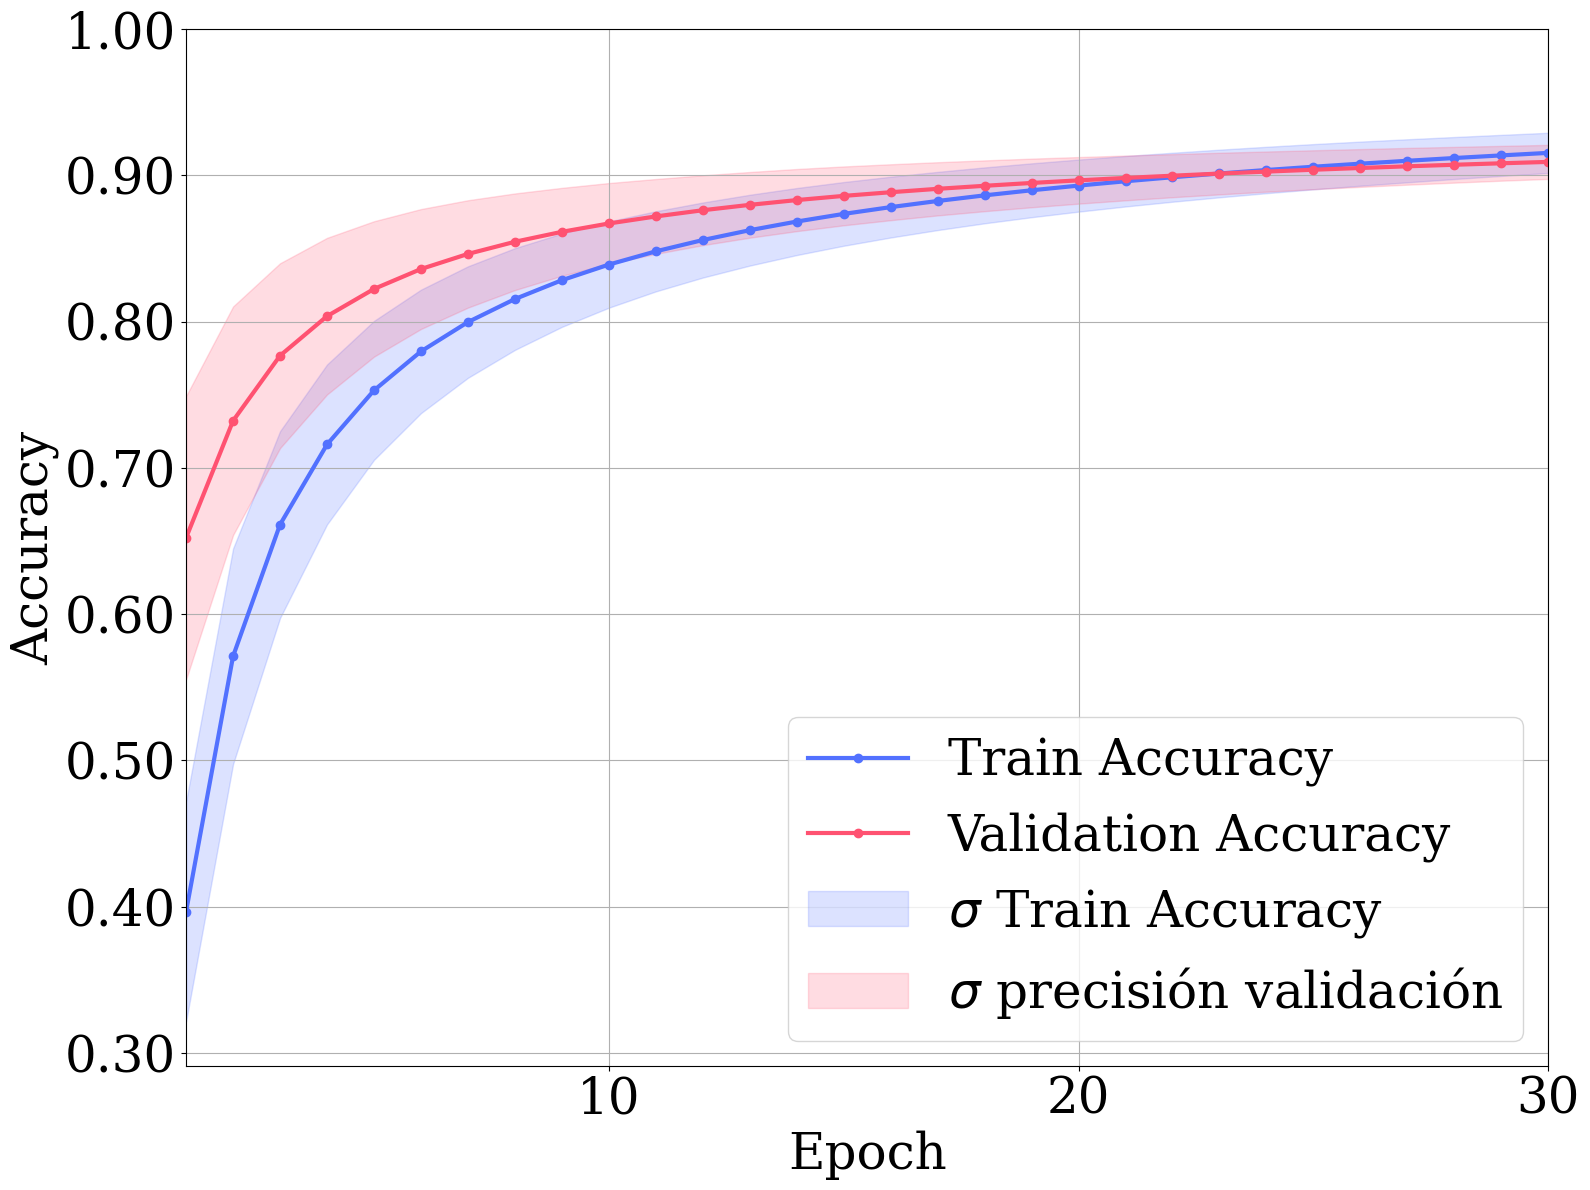

In [ ]:
# Gráfica de precisión

fig = plt.figure(figsize=(16, 12))
ax = plt.gca()
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.plot(range(1, epochs+1), train_acc_mean, '#5271ff', linestyle = "-", marker = "o",
          label='Train Accuracy', lw = 3)
plt.plot(range(1, epochs+1), val_acc_mean,  '#ff5271',
          label='Validation Accuracy', linestyle = '-', marker = 'o', lw = 3)
plt.fill_between(range(1, epochs+1),
                 train_acc_mean - train_acc_std,
                 train_acc_mean + train_acc_std,
                 label = r'$\sigma$ Train Accuracy',
                 alpha=0.2, color = '#5271ff')

plt.fill_between(range(1, epochs+1),
                 val_acc_mean - val_acc_std,
                 val_acc_mean + val_acc_std,
                 label = r'$\sigma$ precisión validación',
                 alpha=0.2, color = '#ff5271')
plt.xlabel('Epoch',fontsize=36)
plt.ylabel(r'Accuracy',fontsize=36)
plt.xlim([1, epochs])
plt.ylim(top=1)
plt.grid()
plt.legend(fontsize=36,loc = 'lower right')
plt.xticks(np.arange(10, epochs+1, step=10), fontsize=36)
plt.yticks(fontsize=36)
plt.tight_layout()
nameFile = 'presicionModelo4Capas-RegularizacionLBA' +'.pdf'
plt.tight_layout()
plt.savefig(nameFile)

# Modelo con regularización L2

In [ ]:
# Función optimizada de entrenamiento
def train_model_with_l2_reg(model, X_train, y_train, X_val, y_val,
                                 epochs=30, l2_lambda=0.01):

    optimizer = tf.keras.optimizers.Adam(0.001)
    loss_fn = tf.keras.losses.CategoricalCrossentropy()

    train_acc_metric = tf.keras.metrics.CategoricalAccuracy()
    val_acc_metric = tf.keras.metrics.CategoricalAccuracy()

    history = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': []}


    for epoch in range(epochs):
        print(f"\nÉpoca {epoch+1}/{epochs}")



        n_batch = 400
        # Entrenamiento por lotes
        for step in range(len(X_train) // n_batch):  # Asumiendo batch_size=32
            batch_X = X_train[step * n_batch:(step + 1) * n_batch]
            batch_y = y_train[step * n_batch:(step + 1) * n_batch]



            with tf.GradientTape() as tape:
                logits = model(batch_X, training=True)
                loss = loss_fn(batch_y, logits)

                if l2_lambda != 0:  # Calcular solo cada `reg_update_freq` épocas
                  l2_loss = 0.0
                  for layer in model.layers:
                      if isinstance(layer, Dense):
                          l2_loss += tf.nn.l2_loss(layer.kernel)  # L2 norm of weights
                  reg_loss = l2_lambda * l2_loss
                  total_loss = loss + reg_loss
                else:
                    total_loss = loss

            gradients = tape.gradient(total_loss, model.trainable_weights)
            optimizer.apply_gradients(zip(gradients, model.trainable_weights))

            train_acc_metric.update_state(batch_y, logits)

        # Validación
        val_logits = model.predict(X_val, verbose=0)
        val_loss = loss_fn(y_val, val_logits)
        val_acc_metric.update_state(y_val, val_logits)

        # Guardar métricas
        history['loss'].append(total_loss.numpy())
        history['accuracy'].append(train_acc_metric.result().numpy())
        history['val_loss'].append(val_loss.numpy())
        history['val_accuracy'].append(val_acc_metric.result().numpy())

        print(f"Acc: {train_acc_metric.result().numpy()}, Val Acc: {val_acc_metric.result().numpy()}")



    return history, model

## Sintonización hiperparámetro

In [ ]:
# Definir la rejilla de hiperparámetros
param_grid = [l2(0.1), l2(0.01), l2(0.001), l2(0.0001)]
kf = KFold(n_splits=3, shuffle=True, random_state=42)

In [ ]:
# Ajuste de hiperparámetros
for param in param_grid:
    print(f'Probando regularización L2: {param.l2}')
    acc_train = []
    acc_test = []

    for train_index, test_index in kf.split(X_train):
        model = load_model(n=n_blocks, filters=filters, kernel_size=kernel_size, regular_l=param)

        model.compile(
            loss='categorical_crossentropy',
            optimizer='SGD',
            metrics=['accuracy']
        )
        # Entrenamiento
        model.fit(
            X_train[train_index],
            y_train_onehot[train_index],
            epochs=30,
            verbose=0
        )
        # Evaluación
        train_acc = model.evaluate(X_train[train_index], y_train_onehot[train_index], verbose=0)[1]
        test_acc = model.evaluate(X_train[test_index], y_train_onehot[test_index], verbose=0)[1]
        acc_train.append(train_acc)
        acc_test.append(test_acc)
        print(f'Pliegue: Accuracy Entrenamiento: {train_acc:.4f}, Prueba: {test_acc:.4f}')

    # Promedios y desviación estándar
    print(f'Promedio Entrenamiento: {np.mean(acc_train):.4f}, Desviación: {np.std(acc_train):.4f}')
    print(f'Promedio Prueba: {np.mean(acc_test):.4f}, Desviación: {np.std(acc_test):.4f}')
    print('-' * 50)

Probando regularización L2: 0.1
Pliegue: Accuracy Entrenamiento: 0.2810, Prueba: 0.2684
Pliegue: Accuracy Entrenamiento: 0.3055, Prueba: 0.2817
Pliegue: Accuracy Entrenamiento: 0.3339, Prueba: 0.3057
Promedio Entrenamiento: 0.3068, Desviación: 0.0216
Promedio Prueba: 0.2853, Desviación: 0.0154
--------------------------------------------------
Probando regularización L2: 0.01
Pliegue: Accuracy Entrenamiento: 0.7430, Prueba: 0.5030
Pliegue: Accuracy Entrenamiento: 0.6375, Prueba: 0.4710
Pliegue: Accuracy Entrenamiento: 0.7144, Prueba: 0.4848
Promedio Entrenamiento: 0.6983, Desviación: 0.0446
Promedio Prueba: 0.4863, Desviación: 0.0131
--------------------------------------------------
Probando regularización L2: 0.001
Pliegue: Accuracy Entrenamiento: 0.9475, Prueba: 0.5414
Pliegue: Accuracy Entrenamiento: 0.7558, Prueba: 0.4677
Pliegue: Accuracy Entrenamiento: 0.9060, Prueba: 0.5317
Promedio Entrenamiento: 0.8698, Desviación: 0.0823
Promedio Prueba: 0.5136, Desviación: 0.0327
----------

## Entrenamiento mejor parámetro

In [ ]:
regularization_factor  = l.l2(0.001)  # Regularización con el mejor parametro L2

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
epochs = 30
acc_train = []
acc_val = []
acc_test = []
histories = []
times = []

time_start_total = time.time()
for i, (train_index, test_index) in enumerate(kf.split(X_train)):
    print(f'\nEntrenando pliegue {i+1}')
    time_start = time.time()
    # Crear modelo nuevo por pliegue

    n_blocks = 4  # Número de bloques residuales convolucionales
    regularization = l.l2(0)  # Regularización L2
    dropout = 0 # Tasa de desconeción

    model = load_model(n=n_blocks,
                       regular_l=regularization,
                       dropout_rate=dropout)


    # Datos del fold
    X_train_fold, X_val_fold = X_train[train_index], X_train[test_index]
    y_train_fold, y_val_fold = y_train_onehot[train_index], y_train_onehot[test_index]

    # Entrenamiento con regularización dinámica
    history, model = train_model_with_l2_reg(
        model, X_train_fold, y_train_fold, X_val_fold, y_val_fold,
        epochs=epochs, l2_lambda = 0.01
    )


    histories.append(history)
    # Guardar métricas y historial

    acc_final_train = history['accuracy'][-1]
    acc_final_val = history['val_accuracy'][-1]

    test_predictions = model.predict(X_test, verbose=0)
    acc_final_test = sklearn.metrics.accuracy_score(y_true=y_test, y_pred=np.argmax(test_predictions, axis=-1))


    acc_train.append(acc_final_train)
    acc_val.append(acc_final_val)
    acc_test.append(acc_final_test)

    time_end = time.time()
    times.append(time_end -  time_start)
    print(f'Pliegue {i+1} - Accuracy: {acc_final_train:.4f} - Val Accuracy: {acc_final_val:.4f} - Test Accuracy:{acc_final_test:.4f} - Time {time_end -  time_start}')

time_end_total = time.time()
# Resultados finales
print(f'\nFinal Results --------------------------------------------')
print(f'\nMean Train Accuracy: {np.mean(acc_train):.4f} ± {np.std(acc_train):.4f}')
print(f'Mean Val Accuracy: {np.mean(acc_val):.4f} ± {np.std(acc_val):.4f}')
print(f'Mean Test Accuracy: {np.mean(acc_test):.4f} ± {np.std(acc_test):.4f}')
print(f'Mean Times per fold: {np.mean(times):.2f}± {np.std(times):.2f}')
print(f'Total Time:{time_end_total-time_start_total:.0f}')
print(f'-------------------------------------------------------------')


Entrenando pliegue 1

Época 1/30
Acc: 0.3407500088214874, Val Acc: 0.6244999766349792

Época 2/30
Acc: 0.5373125076293945, Val Acc: 0.7294999957084656

Época 3/30
Acc: 0.6440833210945129, Val Acc: 0.7825000286102295

Época 4/30
Acc: 0.7060312628746033, Val Acc: 0.8138750195503235

Época 5/30
Acc: 0.7472000122070312, Val Acc: 0.8342000246047974

Época 6/30
Acc: 0.776479184627533, Val Acc: 0.8489999771118164

Época 7/30
Acc: 0.7983928322792053, Val Acc: 0.859928548336029

Época 8/30
Acc: 0.8155468702316284, Val Acc: 0.8685625195503235

Época 9/30
Acc: 0.8295555710792542, Val Acc: 0.8757222294807434

Época 10/30
Acc: 0.8411250114440918, Val Acc: 0.8816499710083008

Época 11/30
Acc: 0.8510568141937256, Val Acc: 0.8866817951202393

Época 12/30
Acc: 0.8595208525657654, Val Acc: 0.890958309173584

Época 13/30
Acc: 0.8669230937957764, Val Acc: 0.8947307467460632

Época 14/30
Acc: 0.8735178709030151, Val Acc: 0.8981428742408752

Época 15/30
Acc: 0.8793833255767822, Val Acc: 0.9012666940689087


In [ ]:
# Inicializar listas para almacenar las métricas por época
epochs = len(histories[0]['loss'])
train_loss_all = np.zeros((len(histories), epochs))
val_loss_all = np.zeros((len(histories), epochs))
train_acc_all = np.zeros((len(histories), epochs))
val_acc_all = np.zeros((len(histories), epochs))

# Extraer métricas de cada pliegue
for i, history in enumerate(histories):
    train_loss_all[i, :] = history['loss']
    val_loss_all[i, :] = history['val_loss']
    train_acc_all[i, :] = history['accuracy']
    val_acc_all[i, :] = history['val_accuracy']

# Promedio y desviación estándar
train_loss_mean = np.mean(train_loss_all, axis=0)
train_loss_std = np.std(train_loss_all, axis=0)
val_loss_mean = np.mean(val_loss_all, axis=0)
val_loss_std = np.std(val_loss_all, axis=0)

train_acc_mean = np.mean(train_acc_all, axis=0)
train_acc_std = np.std(train_acc_all, axis=0)
val_acc_mean = np.mean(val_acc_all, axis=0)
val_acc_std = np.std(val_acc_all, axis=0)

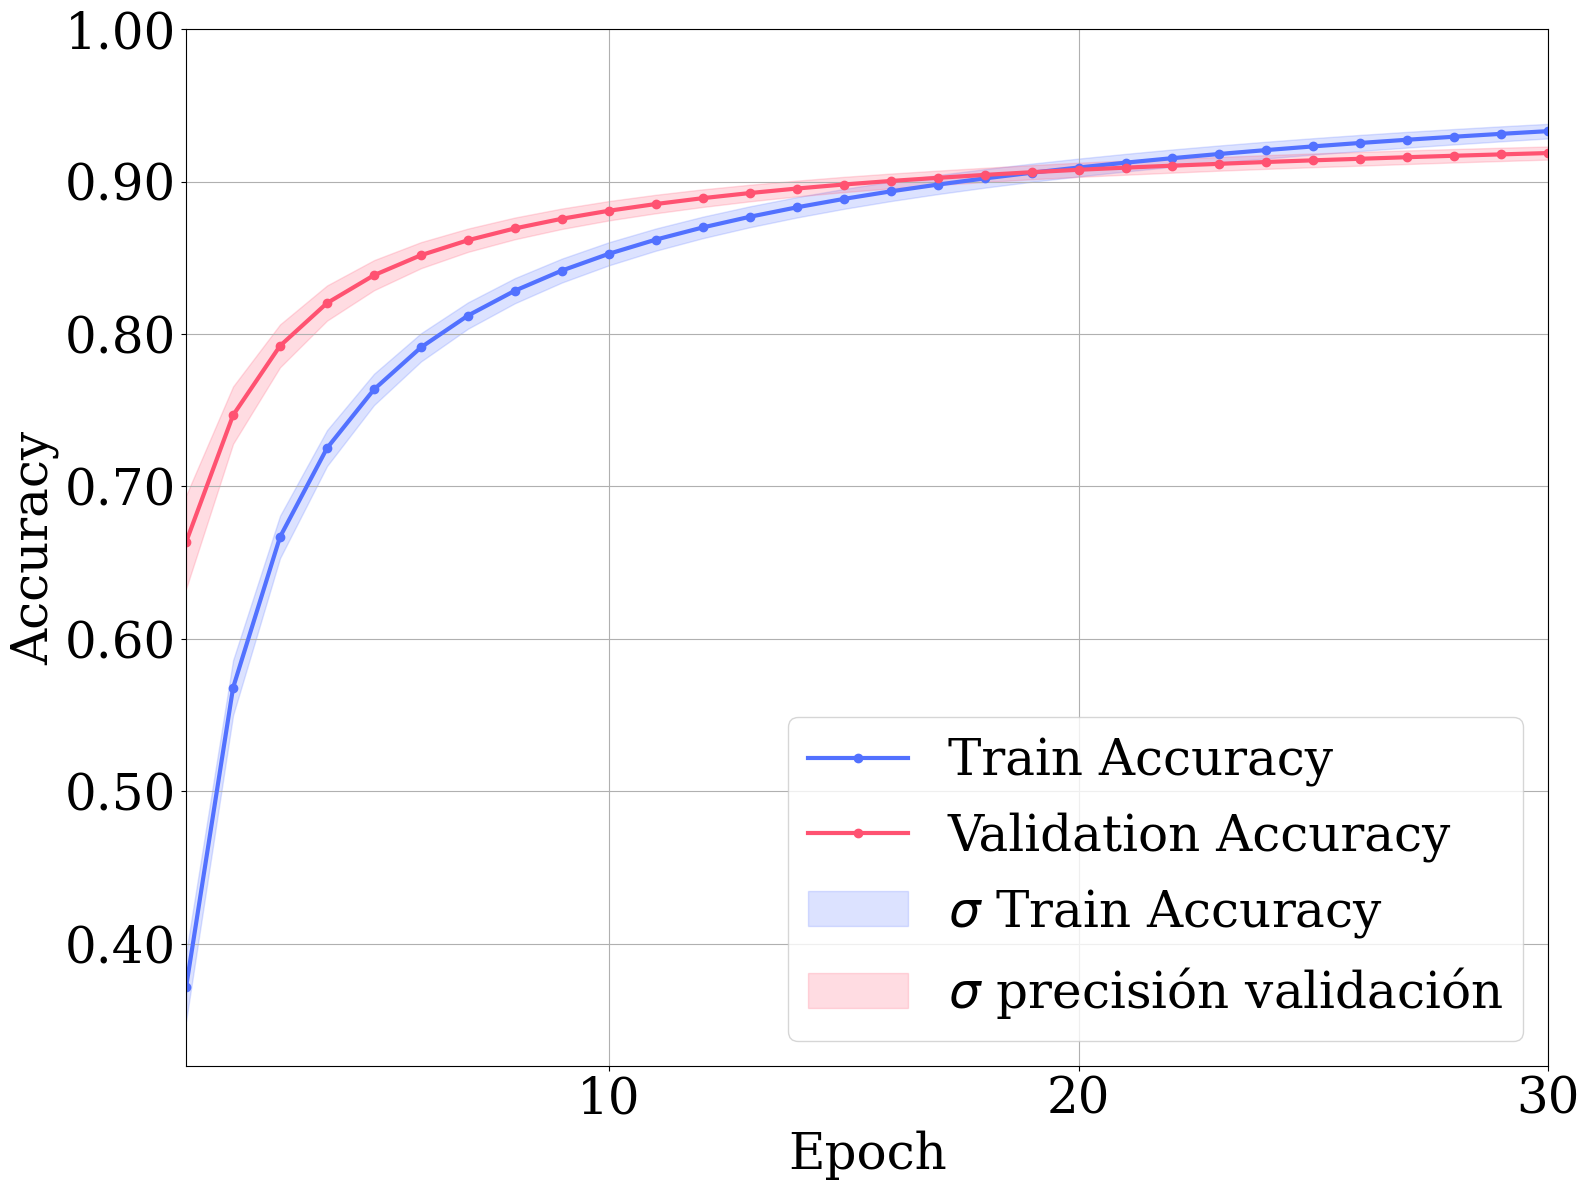

In [ ]:
# Gráfica de precisión

fig = plt.figure(figsize=(16, 12))
ax = plt.gca()
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.plot(range(1, epochs+1), train_acc_mean, '#5271ff', linestyle = "-", marker = "o",
          label='Train Accuracy', lw = 3)
plt.plot(range(1, epochs+1), val_acc_mean,  '#ff5271',
          label='Validation Accuracy', linestyle = '-', marker = 'o', lw = 3)
plt.fill_between(range(1, epochs+1),
                 train_acc_mean - train_acc_std,
                 train_acc_mean + train_acc_std,
                 label = r'$\sigma$ Train Accuracy',
                 alpha=0.2, color = '#5271ff')

plt.fill_between(range(1, epochs+1),
                 val_acc_mean - val_acc_std,
                 val_acc_mean + val_acc_std,
                 label = r'$\sigma$ precisión validación',
                 alpha=0.2, color = '#ff5271')
plt.xlabel('Epoch',fontsize=36)
plt.ylabel(r'Accuracy',fontsize=36)
plt.xlim([1, epochs])
plt.ylim(top=1)
plt.grid()
plt.legend(fontsize=36,loc = 'lower right')
plt.xticks(np.arange(10, epochs+1, step=10), fontsize=36)
plt.yticks(fontsize=36)
plt.tight_layout()
nameFile = 'presicionModelo4Capas-RegularizacionL2' +'.pdf'
plt.tight_layout()
plt.savefig(nameFile)

# Modelo regularización L1

In [ ]:
# Función optimizada de entrenamiento
def train_model_with_l1_reg(model, X_train, y_train, X_val, y_val,
                                 epochs=30, l1_lambda=0.01):

    optimizer = tf.keras.optimizers.Adam(0.001)
    loss_fn = tf.keras.losses.CategoricalCrossentropy()

    train_acc_metric = tf.keras.metrics.CategoricalAccuracy()
    val_acc_metric = tf.keras.metrics.CategoricalAccuracy()

    history = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': []}


    for epoch in range(epochs):
        print(f"\nÉpoca {epoch+1}/{epochs}")



        n_batch = 400
        # Entrenamiento por lotes
        for step in range(len(X_train) // n_batch):  # Asumiendo batch_size=32
            batch_X = X_train[step * n_batch:(step + 1) * n_batch]
            batch_y = y_train[step * n_batch:(step + 1) * n_batch]



            with tf.GradientTape() as tape:
                logits = model(batch_X, training=True)
                loss = loss_fn(batch_y, logits)

                if l1_lambda != 0:  # Calcular solo cada `reg_update_freq` épocas
                  l1_loss = 0.0
                  for layer in model.layers:
                      if isinstance(layer, Dense):
                          l1_loss += tf.reduce_sum(tf.abs(layer.kernel))  # L1 norm of weights  # L2 norm of weights
                  reg_loss = l1_lambda * l1_loss
                  total_loss = loss + reg_loss
                else:
                    total_loss = loss

            gradients = tape.gradient(total_loss, model.trainable_weights)
            optimizer.apply_gradients(zip(gradients, model.trainable_weights))

            train_acc_metric.update_state(batch_y, logits)

        # Validación
        val_logits = model.predict(X_val, verbose=0)
        val_loss = loss_fn(y_val, val_logits)
        val_acc_metric.update_state(y_val, val_logits)

        # Guardar métricas
        history['loss'].append(total_loss.numpy())
        history['accuracy'].append(train_acc_metric.result().numpy())
        history['val_loss'].append(val_loss.numpy())
        history['val_accuracy'].append(val_acc_metric.result().numpy())

        print(f"Acc: {train_acc_metric.result().numpy()}, Val Acc: {val_acc_metric.result().numpy()}")


    return history, model

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
epochs = 30
acc_train = []
acc_val = []
acc_test = []
histories = []
times = []

time_start_total = time.time()
for i, (train_index, test_index) in enumerate(kf.split(X_train)):
    print(f'\nEntrenando pliegue {i+1}')
    time_start = time.time()
    # Crear modelo nuevo por pliegue

    n_blocks = 4  # Número de bloques residuales convolucionales
    regularization = l.l2(0)  # Regularización L2
    dropout = 0 # Tasa de desconeción

    model = load_model(n=n_blocks,
                       regular_l=regularization,
                       dropout_rate=dropout)


    # Datos del fold
    X_train_fold, X_val_fold = X_train[train_index], X_train[test_index]
    y_train_fold, y_val_fold = y_train_onehot[train_index], y_train_onehot[test_index]

    # Entrenamiento con regularización dinámica
    history, model = train_model_with_l1_reg(
        model, X_train_fold, y_train_fold, X_val_fold, y_val_fold,
        epochs=epochs, l1_lambda = 0.001
    )


    histories.append(history)
    # Guardar métricas y historial

    acc_final_train = history['accuracy'][-1]
    acc_final_val = history['val_accuracy'][-1]

    test_predictions = model.predict(X_test, verbose=0)
    acc_final_test = sklearn.metrics.accuracy_score(y_true=y_test, y_pred=np.argmax(test_predictions, axis=-1))


    acc_train.append(acc_final_train)
    acc_val.append(acc_final_val)
    acc_test.append(acc_final_test)

    time_end = time.time()
    times.append(time_end -  time_start)
    print(f'Pliegue {i+1} - Accuracy: {acc_final_train:.4f} - Val Accuracy: {acc_final_val:.4f} - Test Accuracy:{acc_final_test:.4f} - Time {time_end -  time_start}')

time_end_total = time.time()
# Resultados finales
print(f'\nFinal Results --------------------------------------------')
print(f'\nMean Train Accuracy: {np.mean(acc_train):.4f} ± {np.std(acc_train):.4f}')
print(f'Mean Val Accuracy: {np.mean(acc_val):.4f} ± {np.std(acc_val):.4f}')
print(f'Mean Test Accuracy: {np.mean(acc_test):.4f} ± {np.std(acc_test):.4f}')
print(f'Mean Times per fold: {np.mean(times):.2f}± {np.std(times):.2f}')
print(f'Total Time:{time_end_total-time_start_total:.0f}')
print(f'-------------------------------------------------------------')


Entrenando pliegue 1

Época 1/30
Acc: 0.367125004529953, Val Acc: 0.6510000228881836

Época 2/30
Acc: 0.5571874976158142, Val Acc: 0.7387499809265137

Época 3/30
Acc: 0.6550416946411133, Val Acc: 0.7885000109672546

Época 4/30
Acc: 0.7135000228881836, Val Acc: 0.8174999952316284

Época 5/30
Acc: 0.7523249983787537, Val Acc: 0.8374999761581421

Época 6/30
Acc: 0.7803750038146973, Val Acc: 0.8515833616256714

Época 7/30
Acc: 0.8011785745620728, Val Acc: 0.8624285459518433

Época 8/30
Acc: 0.8174218535423279, Val Acc: 0.8705000281333923

Época 9/30
Acc: 0.8306388854980469, Val Acc: 0.8769444227218628

Época 10/30
Acc: 0.8413500189781189, Val Acc: 0.8823999762535095

Época 11/30
Acc: 0.8503522872924805, Val Acc: 0.88718181848526

Época 12/30
Acc: 0.8580625057220459, Val Acc: 0.8913333415985107

Época 13/30
Acc: 0.8647980690002441, Val Acc: 0.8947692513465881

Época 14/30
Acc: 0.8707231879234314, Val Acc: 0.8977500200271606

Época 15/30
Acc: 0.8760166764259338, Val Acc: 0.9005666375160217


In [ ]:
# Inicializar listas para almacenar las métricas por época
epochs = len(histories[0]['loss'])
train_loss_all = np.zeros((len(histories), epochs))
val_loss_all = np.zeros((len(histories), epochs))
train_acc_all = np.zeros((len(histories), epochs))
val_acc_all = np.zeros((len(histories), epochs))

# Extraer métricas de cada pliegue
for i, history in enumerate(histories):
    train_loss_all[i, :] = history['loss']
    val_loss_all[i, :] = history['val_loss']
    train_acc_all[i, :] = history['accuracy']
    val_acc_all[i, :] = history['val_accuracy']

# Promedio y desviación estándar
train_loss_mean = np.mean(train_loss_all, axis=0)
train_loss_std = np.std(train_loss_all, axis=0)
val_loss_mean = np.mean(val_loss_all, axis=0)
val_loss_std = np.std(val_loss_all, axis=0)

train_acc_mean = np.mean(train_acc_all, axis=0)
train_acc_std = np.std(train_acc_all, axis=0)
val_acc_mean = np.mean(val_acc_all, axis=0)
val_acc_std = np.std(val_acc_all, axis=0)

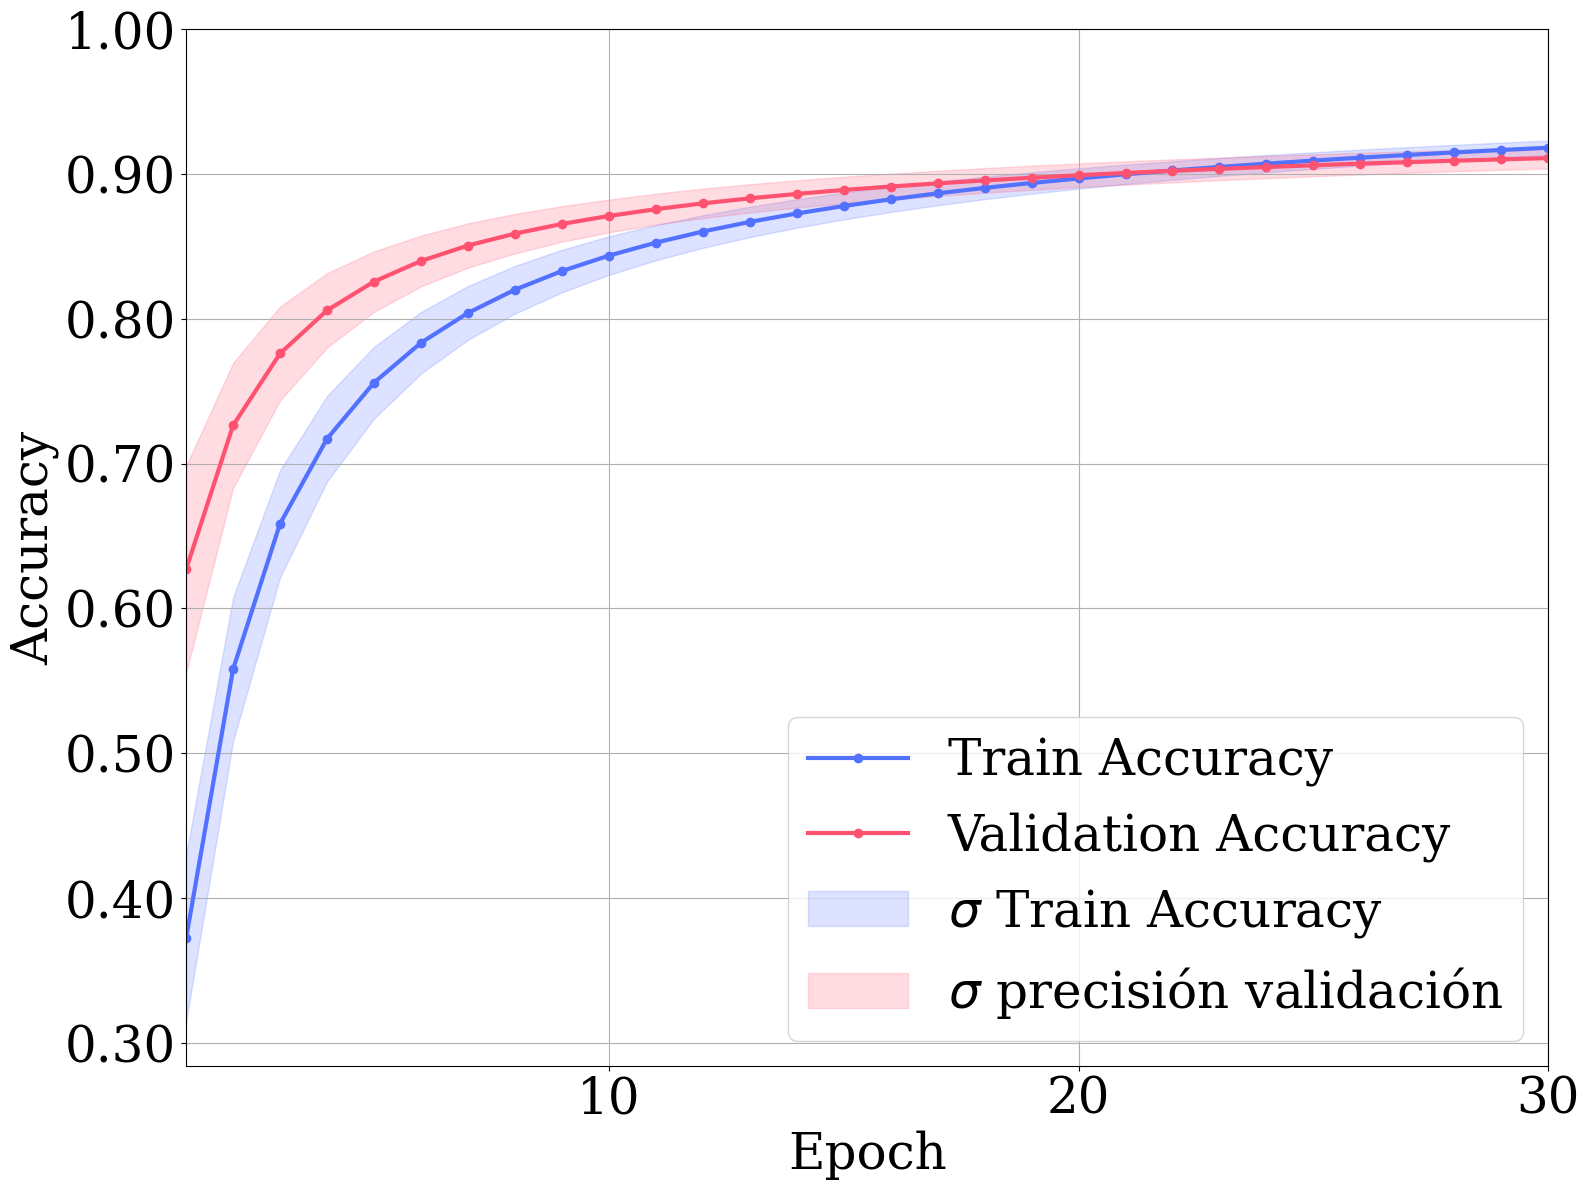

In [ ]:
# Gráfica de precisión

fig = plt.figure(figsize=(16, 12))
ax = plt.gca()
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.plot(range(1, epochs+1), train_acc_mean, '#5271ff', linestyle = "-", marker = "o",
          label='Train Accuracy', lw = 3)
plt.plot(range(1, epochs+1), val_acc_mean,  '#ff5271',
          label='Validation Accuracy', linestyle = '-', marker = 'o', lw = 3)
plt.fill_between(range(1, epochs+1),
                 train_acc_mean - train_acc_std,
                 train_acc_mean + train_acc_std,
                 label = r'$\sigma$ Train Accuracy',
                 alpha=0.2, color = '#5271ff')

plt.fill_between(range(1, epochs+1),
                 val_acc_mean - val_acc_std,
                 val_acc_mean + val_acc_std,
                 label = r'$\sigma$ precisión validación',
                 alpha=0.2, color = '#ff5271')
plt.xlabel('Epoch',fontsize=36)
plt.ylabel(r'Accuracy',fontsize=36)
plt.xlim([1, epochs])
plt.ylim(top=1)
plt.grid()
plt.legend(fontsize=36,loc = 'lower right')
plt.xticks(np.arange(10, epochs+1, step=10), fontsize=36)
plt.yticks(fontsize=36)
plt.tight_layout()
nameFile = 'presicionModelo4Capas-RegularizacionL1' +'.pdf'
plt.tight_layout()
plt.savefig(nameFile)



---



# Modelo con dropout

### Sintonización hiperparámetro

In [ ]:
param_grid = [ 0.2, 0.4, 0.6, 0.8]
kf = KFold(n_splits=3, shuffle=True, random_state=42)

In [ ]:
# Ajuste de hiperparámetros
for param in param_grid:
    print(f'Probando regularización Dropout: {param}')
    acc_train = []
    acc_test = []

    for train_index, test_index in kf.split(X_train):
        model = load_model(n=n_blocks, filters=filters,
                           kernel_size=kernel_size, regular_l1=l2(0),
                           dropout_rate= param)

        model.compile(
            loss='categorical_crossentropy',
            optimizer='SGD',
            metrics=['accuracy']
        )
        # Entrenamiento
        model.fit(
            X_train[train_index],
            y_train_onehot[train_index],
            epochs=30,
            verbose=0
        )
        # Evaluación
        train_acc = model.evaluate(X_train[train_index], y_train_onehot[train_index], verbose=0)[1]
        test_acc = model.evaluate(X_train[test_index], y_train_onehot[test_index], verbose=0)[1]
        acc_train.append(train_acc)
        acc_test.append(test_acc)
        print(f'Pliegue: Accuracy Entrenamiento: {train_acc:.4f}, Prueba: {test_acc:.4f}')

    # Promedios y desviación estándar
    print(f'Promedio Entrenamiento: {np.mean(acc_train):.4f}, Desviación: {np.std(acc_train):.4f}')
    print(f'Promedio Prueba: {np.mean(acc_test):.4f}, Desviación: {np.std(acc_test):.4f}')
    print('-' * 50)

Probando regularización Dropout: 0.2
Pliegue: Accuracy Entrenamiento: 0.7075, Prueba: 0.4883
Pliegue: Accuracy Entrenamiento: 0.7957, Prueba: 0.4866
Pliegue: Accuracy Entrenamiento: 0.6783, Prueba: 0.4569
Promedio Entrenamiento: 0.7271, Desviación: 0.0499
Promedio Prueba: 0.4773, Desviación: 0.0144
--------------------------------------------------
Probando regularización Dropout: 0.4
Pliegue: Accuracy Entrenamiento: 0.5611, Prueba: 0.4427
Pliegue: Accuracy Entrenamiento: 0.5569, Prueba: 0.4407
Pliegue: Accuracy Entrenamiento: 0.6103, Prueba: 0.4740
Promedio Entrenamiento: 0.5761, Desviación: 0.0243
Promedio Prueba: 0.4525, Desviación: 0.0153
--------------------------------------------------
Probando regularización Dropout: 0.6
Pliegue: Accuracy Entrenamiento: 0.4637, Prueba: 0.3803
Pliegue: Accuracy Entrenamiento: 0.3985, Prueba: 0.3171
Pliegue: Accuracy Entrenamiento: 0.3459, Prueba: 0.2928
Promedio Entrenamiento: 0.4027, Desviación: 0.0482
Promedio Prueba: 0.3301, Desviación: 0.036

In [ ]:
# Configuración de KFold y parámetros
kf = KFold(n_splits=5, shuffle=True, random_state=42)
epochs = 30
acc_train = []
acc_test = []
histories = []  # Para guardar los historiales de cada pliegue

# Iterar sobre los pliegues
for i, (train_index, test_index) in enumerate(kf.split(X_train)):
    print(f'Entrenando pliegue {i+1}')

    # Crear y compilar el modelo para cada pliegue
    model = load_model(n=n_blocks, filters=filters, kernel_size=kernel_size,
                       regular_l1=l2(0), dropout_rate=0.2)
    model.compile(
        loss='categorical_crossentropy',
        optimizer='SGD',
        metrics=['accuracy']
    )

    # Dividir los datos en entrenamiento y prueba
    X_train_fold, X_test_fold = X_train[train_index], X_train[test_index]
    y_train_fold, y_test_fold = y_train_onehot[train_index], y_train_onehot[test_index]

    # Entrenar el modelo
    history = model.fit(
        X_train_fold, y_train_fold,
        validation_data=(X_test_fold, y_test_fold),
        epochs=epochs,
        verbose=1
    )

    # Evaluar el modelo
    train_eval = model.evaluate(X_train_fold, y_train_fold, verbose=0)
    test_eval = model.evaluate(X_test_fold, y_test_fold, verbose=0)

    # Guardar métricas y historial
    acc_train.append(train_eval[1])
    acc_test.append(test_eval[1])
    histories.append(history.history)

    print(f'Pliegue {i+1}: Accuracy Entrenamiento = {train_eval[1]:.4f}, Accuracy Prueba = {test_eval[1]:.4f}')

# Resumen final
print(f'\nPromedio Accuracy Entrenamiento: {np.mean(acc_train):.4f}, STD: {np.std(acc_train):.4f}')
print(f'Promedio Accuracy Prueba: {np.mean(acc_test):.4f}, STD: {np.std(acc_test):.4f}')

Entrenando pliegue 1
Epoch 1/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - accuracy: 0.1103 - loss: 2.5670 - val_accuracy: 0.1045 - val_loss: 2.3066
Epoch 2/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.1488 - loss: 2.2460 - val_accuracy: 0.2425 - val_loss: 2.0312
Epoch 3/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.2556 - loss: 2.0115 - val_accuracy: 0.2770 - val_loss: 1.9522
Epoch 4/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.3335 - loss: 1.8925 - val_accuracy: 0.2915 - val_loss: 1.9263
Epoch 5/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.3537 - loss: 1.7838 - val_accuracy: 0.4140 - val_loss: 1.6945
Epoch 6/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.4123 - loss: 1.6676 - val_accuracy: 0.4130 - val_loss: 1.6496
Epoch 7/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.4401 - loss: 1.5805 - val_accuracy: 0.4420 - val_loss: 1.5737
Epoch 8/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.4578 - l

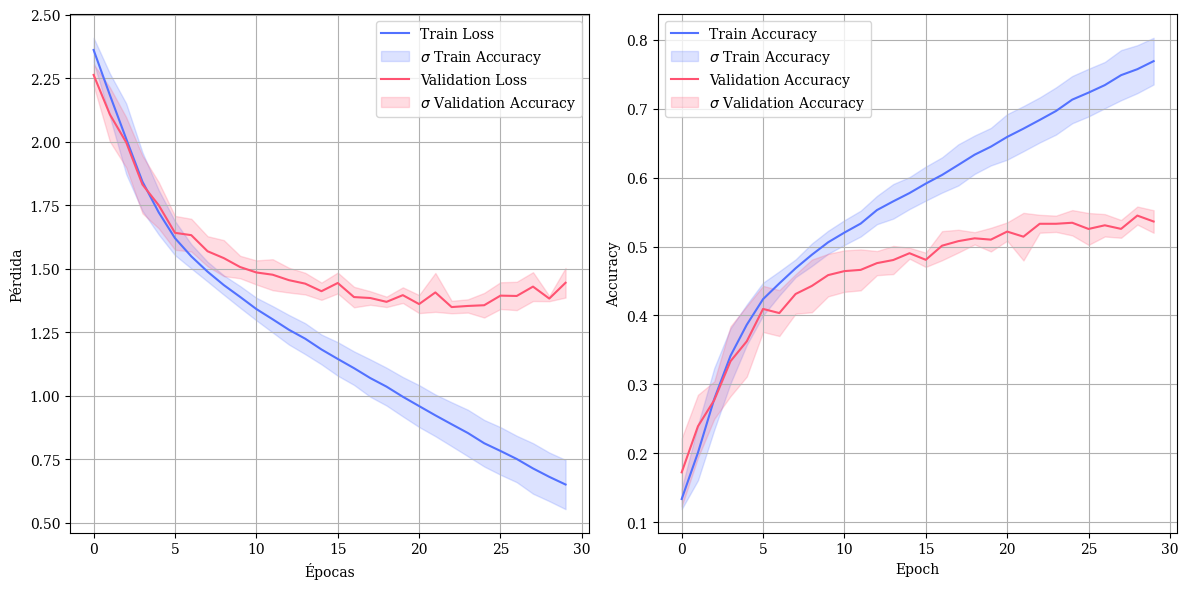

In [ ]:
# Inicializar listas para almacenar las métricas por época
epochs = len(histories[0]['loss'])
train_loss_all = np.zeros((len(histories), epochs))
val_loss_all = np.zeros((len(histories), epochs))
train_acc_all = np.zeros((len(histories), epochs))
val_acc_all = np.zeros((len(histories), epochs))

# Extraer métricas de cada pliegue
for i, history in enumerate(histories):
    train_loss_all[i, :] = history['loss']
    val_loss_all[i, :] = history['val_loss']
    train_acc_all[i, :] = history['accuracy']
    val_acc_all[i, :] = history['val_accuracy']

# Promedio y desviación estándar
train_loss_mean = np.mean(train_loss_all, axis=0)
train_loss_std = np.std(train_loss_all, axis=0)
val_loss_mean = np.mean(val_loss_all, axis=0)
val_loss_std = np.std(val_loss_all, axis=0)

train_acc_mean = np.mean(train_acc_all, axis=0)
train_acc_std = np.std(train_acc_all, axis=0)
val_acc_mean = np.mean(val_acc_all, axis=0)
val_acc_std = np.std(val_acc_all, axis=0)

# Gráfica de pérdida
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_loss_mean, label='Train Loss', color='#5271ff')
plt.fill_between(range(epochs),
                 train_loss_mean - train_loss_std,
                 train_loss_mean + train_loss_std,
                 color='#5271ff', alpha=0.2,
                 label = r'$\sigma$ Train Accuracy')
plt.plot(val_loss_mean, label='Validation Loss', color='#ff5271')
plt.fill_between(range(epochs),
                 val_loss_mean - val_loss_std,
                 val_loss_mean + val_loss_std,
                 color='#ff5271', alpha=0.2,
                 label = r'$\sigma$ Validation Accuracy')

plt.grid()
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

# Gráfica de precisión
plt.subplot(1, 2, 2)
plt.plot(train_acc_mean, label='Train Accuracy', color='#5271ff')
plt.fill_between(range(epochs),
                 train_acc_mean - train_acc_std,
                 train_acc_mean + train_acc_std,
                 color='#5271ff', alpha=0.2,
                 label = r'$\sigma$ Train Accuracy')
plt.plot(val_acc_mean, label='Validation Accuracy', color='#ff5271')
plt.fill_between(range(epochs),
                 val_acc_mean - val_acc_std,
                 val_acc_mean + val_acc_std,
                 color='#ff5271', alpha=0.2,
                 label = r'$\sigma$ Validation Accuracy')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

## Entrenamiento mejor parámetro

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
epochs = 30
acc_train = []
acc_val = []
acc_test = []
histories = []
times = []

time_start_total = time.time()
for i, (train_index, test_index) in enumerate(kf.split(X_train)):
    print(f'\nEntrenando pliegue {i+1}')
    time_start = time.time()
    # Crear modelo nuevo por pliegue

    n_blocks = 4  # Número de bloques residuales convolucionales
    regularization = l.l2(0)  # Regularización L2
    dropout = 0.2 # Tasa de desconeción

    model = load_model(n=n_blocks,
                       regular_l=regularization,
                       dropout_rate=dropout)


    # Datos del fold
    X_train_fold, X_val_fold = X_train[train_index], X_train[test_index]
    y_train_fold, y_val_fold = y_train_onehot[train_index], y_train_onehot[test_index]

    # Entrenamiento con regularización dinámica
    history, model = train_model_with_dynamic_reg(
        model, X_train_fold, y_train_fold, X_val_fold, y_val_fold,
        epochs=epochs, reg_update_freq=1, regularization_flag = False
    )


    histories.append(history)
    # Guardar métricas y historial

    acc_final_train = history['accuracy'][-1]
    acc_final_val = history['val_accuracy'][-1]

    test_predictions = model.predict(X_test, verbose=0)
    acc_final_test = sklearn.metrics.accuracy_score(y_true=y_test, y_pred=np.argmax(test_predictions, axis=-1))


    acc_train.append(acc_final_train)
    acc_val.append(acc_final_val)
    acc_test.append(acc_final_test)

    time_end = time.time()
    times.append(time_end -  time_start)
    print(f'Pliegue {i+1} - Accuracy: {acc_final_train:.4f} - Val Accuracy: {acc_final_val:.4f} - Test Accuracy:{acc_final_test:.4f} - Time {time_end -  time_start}')

time_end_total = time.time()
# Resultados finales
print(f'\nFinal Results --------------------------------------------')
print(f'\nMean Train Accuracy: {np.mean(acc_train):.4f} ± {np.std(acc_train):.4f}')
print(f'Mean Val Accuracy: {np.mean(acc_val):.4f} ± {np.std(acc_val):.4f}')
print(f'Mean Test Accuracy: {np.mean(acc_test):.4f} ± {np.std(acc_test):.4f}')
print(f'Mean Times per fold: {np.mean(times):.2f}± {np.std(times):.2f}')
print(f'Total Time:{time_end_total-time_start_total:.0f}')
print(f'-------------------------------------------------------------')


Entrenando pliegue 1

Época 1/30
Loss: 1.2331, Val Loss: 1.0536
Acc: 0.37812501192092896, Val Acc: 0.7409999966621399

Época 2/30
Loss: 0.6720, Val Loss: 0.5426
Acc: 0.5453125238418579, Val Acc: 0.7935000061988831

Época 3/30
Loss: 0.4778, Val Loss: 0.4125
Acc: 0.6382083296775818, Val Acc: 0.8263333439826965

Época 4/30
Loss: 0.3699, Val Loss: 0.3424
Acc: 0.6961249709129333, Val Acc: 0.8457499742507935

Época 5/30
Loss: 0.3272, Val Loss: 0.2979
Acc: 0.7357249855995178, Val Acc: 0.86080002784729

Época 6/30
Loss: 0.2554, Val Loss: 0.2735
Acc: 0.7639999985694885, Val Acc: 0.871749997138977

Época 7/30
Loss: 0.2449, Val Loss: 0.2525
Acc: 0.7856249809265137, Val Acc: 0.8799285888671875

Época 8/30
Loss: 0.1692, Val Loss: 0.2404
Acc: 0.8029531240463257, Val Acc: 0.8870000243186951

Época 9/30
Loss: 0.1859, Val Loss: 0.2299
Acc: 0.8175833225250244, Val Acc: 0.8924999833106995

Época 10/30
Loss: 0.1892, Val Loss: 0.2208
Acc: 0.8299624919891357, Val Acc: 0.8970999717712402

Época 11/30
Loss: 

In [ ]:
# Inicializar listas para almacenar las métricas por época
epochs = len(histories[0]['loss'])
train_loss_all = np.zeros((len(histories), epochs))
val_loss_all = np.zeros((len(histories), epochs))
train_acc_all = np.zeros((len(histories), epochs))
val_acc_all = np.zeros((len(histories), epochs))

# Extraer métricas de cada pliegue
for i, history in enumerate(histories):
    train_loss_all[i, :] = history['loss']
    val_loss_all[i, :] = history['val_loss']
    train_acc_all[i, :] = history['accuracy']
    val_acc_all[i, :] = history['val_accuracy']

# Promedio y desviación estándar
train_loss_mean = np.mean(train_loss_all, axis=0)
train_loss_std = np.std(train_loss_all, axis=0)
val_loss_mean = np.mean(val_loss_all, axis=0)
val_loss_std = np.std(val_loss_all, axis=0)

train_acc_mean = np.mean(train_acc_all, axis=0)
train_acc_std = np.std(train_acc_all, axis=0)
val_acc_mean = np.mean(val_acc_all, axis=0)
val_acc_std = np.std(val_acc_all, axis=0)

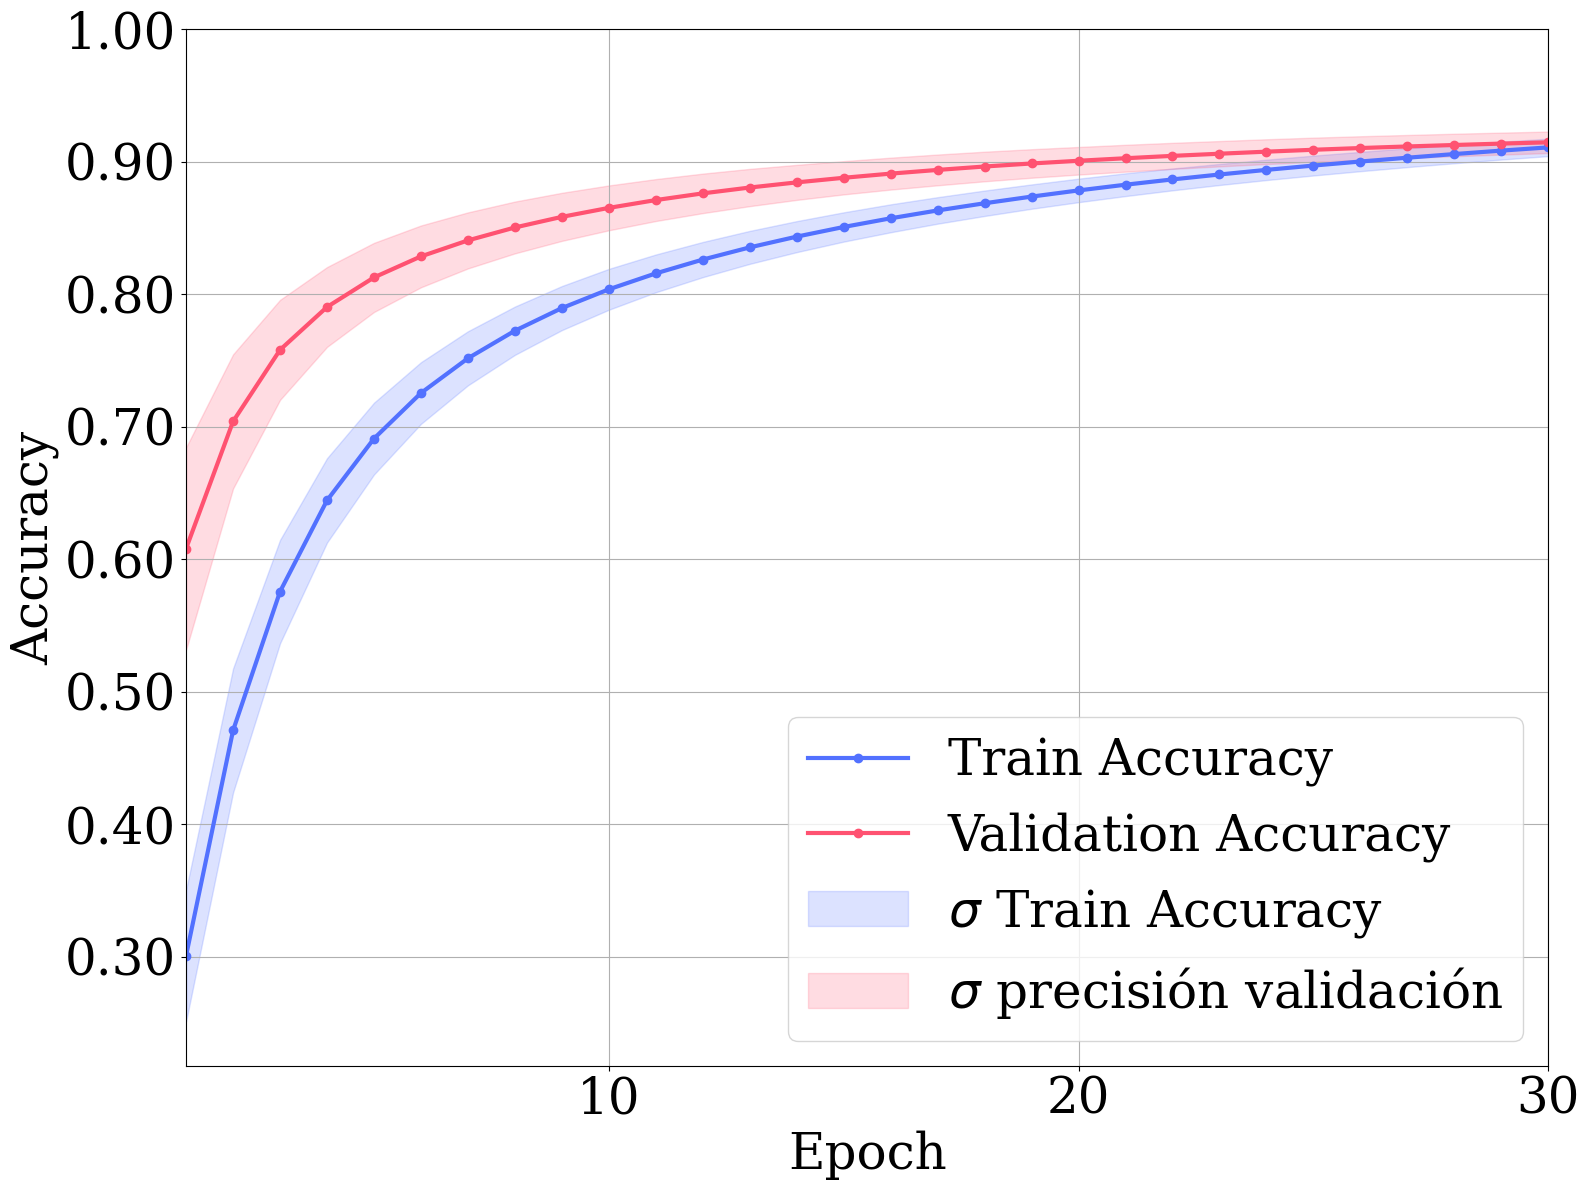

In [ ]:
# Gráfica de precisión

fig = plt.figure(figsize=(16, 12))
ax = plt.gca()
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.plot(range(1, epochs+1), train_acc_mean, '#5271ff', linestyle = "-", marker = "o",
          label='Train Accuracy', lw = 3)
plt.plot(range(1, epochs+1), val_acc_mean,  '#ff5271',
          label='Validation Accuracy', linestyle = '-', marker = 'o', lw = 3)
plt.fill_between(range(1, epochs+1),
                 train_acc_mean - train_acc_std,
                 train_acc_mean + train_acc_std,
                 label = r'$\sigma$ Train Accuracy',
                 alpha=0.2, color = '#5271ff')

plt.fill_between(range(1, epochs+1),
                 val_acc_mean - val_acc_std,
                 val_acc_mean + val_acc_std,
                 label = r'$\sigma$ precisión validación',
                 alpha=0.2, color = '#ff5271')
plt.xlabel('Epoch',fontsize=36)
plt.ylabel(r'Accuracy',fontsize=36)
plt.xlim([1, epochs])
plt.ylim(top=1)
plt.grid()
plt.legend(fontsize=36,loc = 'lower right')
plt.xticks(np.arange(10, epochs+1, step=10), fontsize=36)
plt.yticks(fontsize=36)
plt.tight_layout()
nameFile = 'presicionModelo4Capas-RegularizacionDO' +'.pdf'
plt.tight_layout()
plt.savefig(nameFile)

# Modelo con earlystop

In [ ]:
def train_model_with_early_stop(model, X_train, y_train, X_val, y_val,
                                 epochs=30, reg_update_freq=5, regularization_flag=True,
                                 early_stopping_patience=5):
    """
    Custom training loop with dynamic regularization and manual early stopping.

    Args:
        model: The neural network model.
        X_train, y_train: Training data and labels.
        X_val, y_val: Validation data and labels.
        epochs: Number of training epochs.
        reg_update_freq: Frequency of updating the Lipschitz factor (for LBA).
        regularization_flag: Whether to apply dynamic regularization.
        early_stopping_patience: Number of epochs to wait for improvement in validation loss.

    Returns:
        history: Training and validation metrics.
        model: Trained model.
    """
    optimizer = tf.keras.optimizers.Adam(0.001)
    loss_fn = tf.keras.losses.CategoricalCrossentropy()

    train_acc_metric = tf.keras.metrics.CategoricalAccuracy()
    val_acc_metric = tf.keras.metrics.CategoricalAccuracy()

    history = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': []}

    # Early stopping variables
    best_val_loss = float('inf')  # Track the best validation loss
    wait = 0  # Counter for epochs without improvement
    stop_training = False  # Flag to stop training

    for epoch in range(epochs):
        if stop_training:
            print(f"\nEarly stopping triggered at epoch {epoch+1}.")
            break

        print(f"\nÉpoca {epoch+1}/{epochs}")

        if regularization_flag and (epoch % reg_update_freq == 0):  # Calcular solo cada `reg_update_freq` épocas
            dense_layers = [l for l in model.layers if isinstance(l, Dense)][1:-1]
            if dense_layers:
                selected_layer = np.random.choice(dense_layers)
                lipschitz_factor = spectral_norm_dense(selected_layer)
                #print(f"Norma espectral calculada en la capa {selected_layer.name}: {lipschitz_factor:.4f}")

        n_batch = 400
        # Entrenamiento por lotes
        for step in range(len(X_train) // n_batch):  # Asumiendo batch_size=32
            batch_X = X_train[step * n_batch:(step + 1) * n_batch]
            batch_y = y_train[step * n_batch:(step + 1) * n_batch]

            with tf.GradientTape() as tape:
                logits = model(batch_X, training=True)
                loss = loss_fn(batch_y, logits)

                if regularization_flag and lipschitz_factor is not None:
                    reg_loss = lipschitz_factor * tf.nn.l2_loss(selected_layer.kernel)
                    total_loss = loss + reg_loss
                else:
                    total_loss = loss

            gradients = tape.gradient(total_loss, model.trainable_weights)
            optimizer.apply_gradients(zip(gradients, model.trainable_weights))

            train_acc_metric.update_state(batch_y, logits)

        # Validación
        val_logits = model.predict(X_val, verbose=0)
        val_loss = loss_fn(y_val, val_logits)
        val_acc_metric.update_state(y_val, val_logits)

        # Guardar métricas
        history['loss'].append(total_loss.numpy())
        history['accuracy'].append(train_acc_metric.result().numpy())
        history['val_loss'].append(val_loss.numpy())
        history['val_accuracy'].append(val_acc_metric.result().numpy())

        # Imprimir métricas
        if regularization_flag and lipschitz_factor is not None:
            print(f"Loss: {total_loss:.4f} (Reg: {reg_loss:.4f}), Val Loss: {val_loss:.4f}")
        else:
            print(f"Loss: {total_loss:.4f}, Val Loss: {val_loss:.4f}")
        print(f"Acc: {train_acc_metric.result().numpy()}, Val Acc: {val_acc_metric.result().numpy()}")

        # Early stopping logic
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            wait = 0  # Reset the counter
        else:
            wait += 1  # Increment the counter

        if wait >= early_stopping_patience:
            stop_training = True  # Trigger early stopping

    return history, model

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
epochs = 30
acc_train = []
acc_val = []
acc_test = []
histories = []
times = []

time_start_total = time.time()
for i, (train_index, test_index) in enumerate(kf.split(X_train)):
    print(f'\nEntrenando pliegue {i+1}')
    time_start = time.time()
    # Crear modelo nuevo por pliegue

    n_blocks = 4  # Número de bloques residuales convolucionales
    regularization = l.l2(0)  # Regularización L2
    dropout = 0 # Tasa de desconeción

    model = load_model(n=n_blocks,
                       regular_l=regularization,
                       dropout_rate=dropout)


    # Datos del fold
    X_train_fold, X_val_fold = X_train[train_index], X_train[test_index]
    y_train_fold, y_val_fold = y_train_onehot[train_index], y_train_onehot[test_index]

    # Entrenamiento con regularización dinámica
    history, model = train_model_with_early_stop(
        model, X_train_fold, y_train_fold, X_val_fold, y_val_fold,
        epochs=epochs, reg_update_freq=1, regularization_flag = False, early_stopping_patience=10
    )

    histories.append(history)
    # Guardar métricas y historial

    acc_final_train = history['accuracy'][-1]
    acc_final_val = history['val_accuracy'][-1]

    test_predictions = model.predict(X_test, verbose=0)
    acc_final_test = sklearn.metrics.accuracy_score(y_true=y_test, y_pred=np.argmax(test_predictions, axis=-1))


    acc_train.append(acc_final_train)
    acc_val.append(acc_final_val)
    acc_test.append(acc_final_test)

    time_end = time.time()
    times.append(time_end -  time_start)
    print(f'Pliegue {i+1} - Accuracy: {acc_final_train:.4f} - Val Accuracy: {acc_final_val:.4f} - Test Accuracy:{acc_final_test:.4f} - Time {time_end -  time_start}')

time_end_total = time.time()
# Resultados finales
print(f'\nFinal Results --------------------------------------------')
print(f'\nMean Train Accuracy: {np.mean(acc_train):.4f} ± {np.std(acc_train):.4f}')
print(f'Mean Val Accuracy: {np.mean(acc_val):.4f} ± {np.std(acc_val):.4f}')
print(f'Mean Test Accuracy: {np.mean(acc_test):.4f} ± {np.std(acc_test):.4f}')
print(f'Mean Times per fold: {np.mean(times):.2f}± {np.std(times):.2f}')
print(f'Total Time:{time_end_total-time_start_total:.0f}')
print(f'-------------------------------------------------------------')


Entrenando pliegue 1

Época 1/30
Loss: 1.0826, Val Loss: 1.0023
Acc: 0.4493750035762787, Val Acc: 0.7505000233650208

Época 2/30
Loss: 0.4694, Val Loss: 0.4336
Acc: 0.6310625076293945, Val Acc: 0.815500020980835

Época 3/30
Loss: 0.3398, Val Loss: 0.3255
Acc: 0.7167083621025085, Val Acc: 0.8463333249092102

Época 4/30
Loss: 0.2855, Val Loss: 0.2826
Acc: 0.7668437361717224, Val Acc: 0.8651250004768372

Época 5/30
Loss: 0.2319, Val Loss: 0.2595
Acc: 0.7998499870300293, Val Acc: 0.8773000240325928

Época 6/30
Loss: 0.1893, Val Loss: 0.2408
Acc: 0.8235833048820496, Val Acc: 0.8862500190734863

Época 7/30
Loss: 0.1616, Val Loss: 0.2267
Acc: 0.8416071534156799, Val Acc: 0.8934999704360962

Época 8/30
Loss: 0.1421, Val Loss: 0.2175
Acc: 0.8560000061988831, Val Acc: 0.898812472820282

Época 9/30
Loss: 0.1233, Val Loss: 0.2106
Acc: 0.867847204208374, Val Acc: 0.9032777547836304

Época 10/30
Loss: 0.1080, Val Loss: 0.2060
Acc: 0.8778250217437744, Val Acc: 0.9070500135421753

Época 11/30
Loss: 0

In [ ]:
import numpy as np

# Determinar la longitud mínima de las historias
min_epochs = min(len(history['loss']) for history in histories)

# Inicializar listas para almacenar las métricas por época
train_loss_all = np.zeros((len(histories), min_epochs))
val_loss_all = np.zeros((len(histories), min_epochs))
train_acc_all = np.zeros((len(histories), min_epochs))
val_acc_all = np.zeros((len(histories), min_epochs))

# Extraer métricas de cada pliegue hasta la longitud mínima
for i, history in enumerate(histories):
    train_loss_all[i, :] = history['loss'][:min_epochs]
    val_loss_all[i, :] = history['val_loss'][:min_epochs]
    train_acc_all[i, :] = history['accuracy'][:min_epochs]
    val_acc_all[i, :] = history['val_accuracy'][:min_epochs]

# Promedio y desviación estándar
train_loss_mean = np.mean(train_loss_all, axis=0)
train_loss_std = np.std(train_loss_all, axis=0)
val_loss_mean = np.mean(val_loss_all, axis=0)
val_loss_std = np.std(val_loss_all, axis=0)

train_acc_mean = np.mean(train_acc_all, axis=0)
train_acc_std = np.std(train_acc_all, axis=0)
val_acc_mean = np.mean(val_acc_all, axis=0)
val_acc_std = np.std(val_acc_all, axis=0)

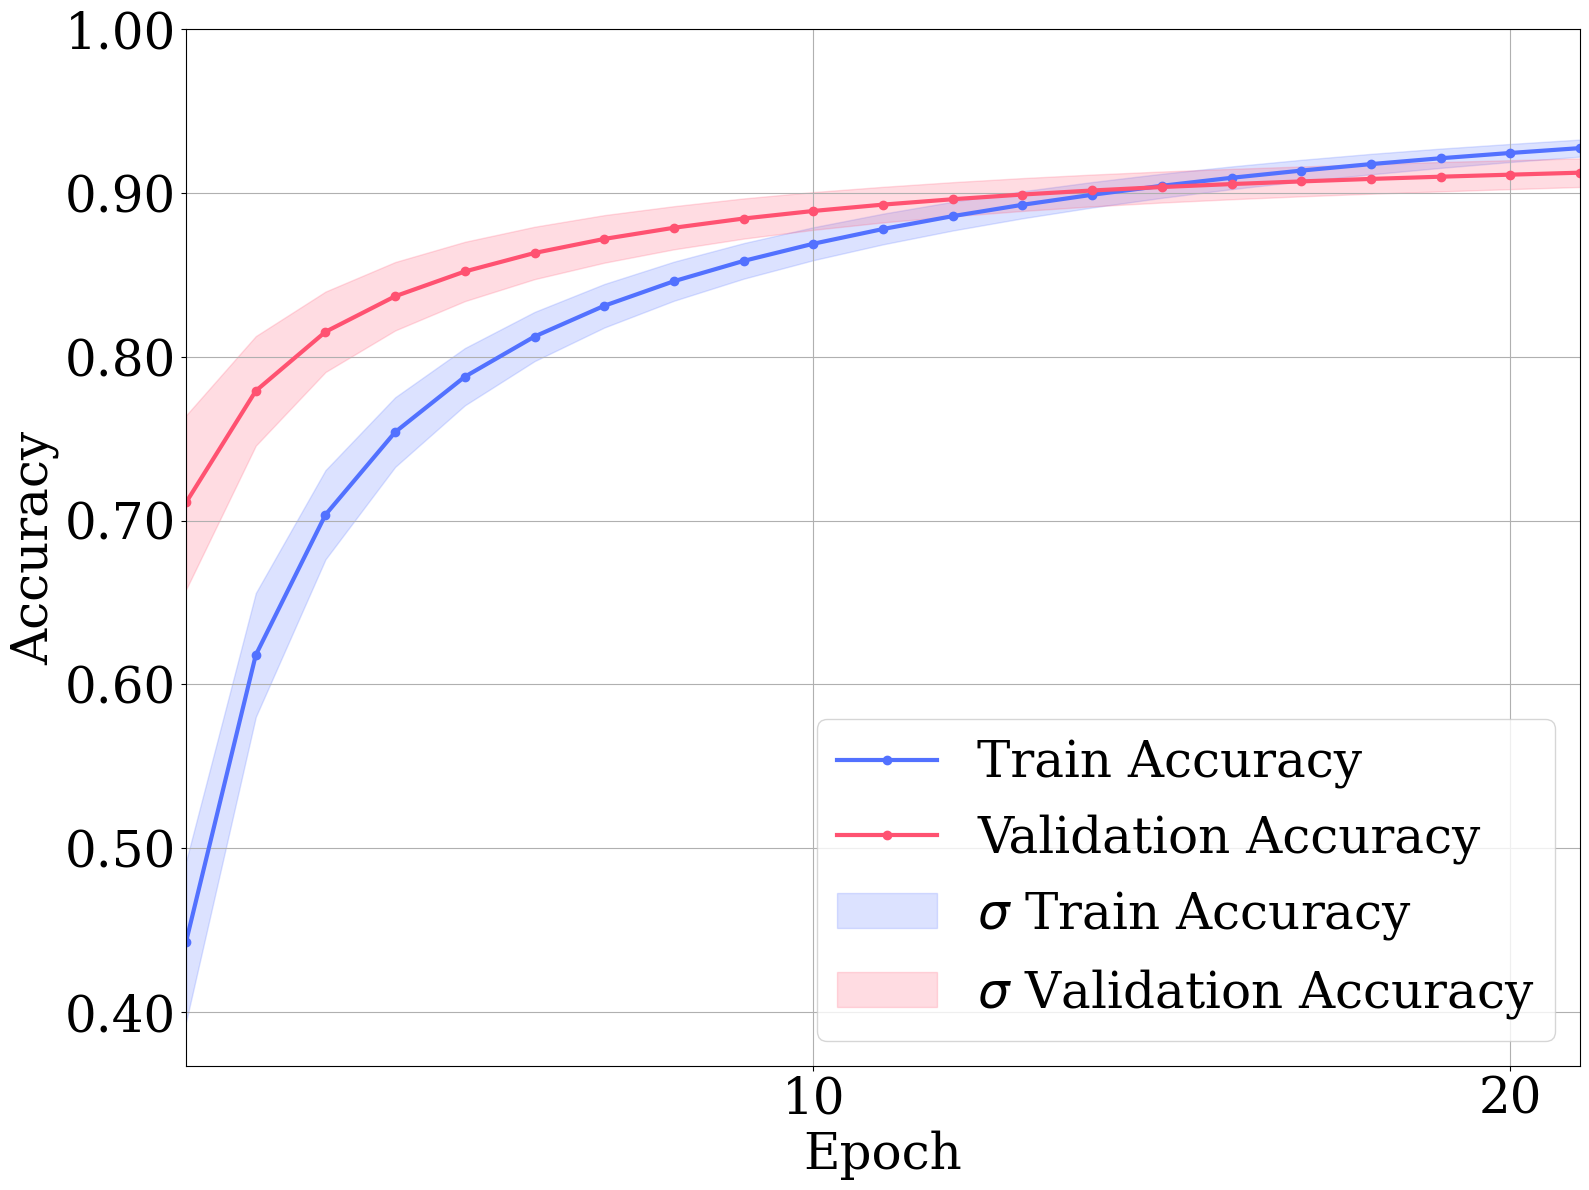

In [ ]:
from matplotlib.ticker import FormatStrFormatter

# Determinar la longitud mínima de las historias
min_epochs = min(len(history['loss']) for history in histories)

# Crear el gráfico
fig = plt.figure(figsize=(16, 12))
ax = plt.gca()
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

# Graficar las métricas hasta la longitud mínima
plt.plot(range(1, min_epochs + 1), train_acc_mean[:min_epochs], '#5271ff', linestyle="-", marker="o",
         label='Train Accuracy', lw=3)
plt.plot(range(1, min_epochs + 1), val_acc_mean[:min_epochs], '#ff5271',
         label='Validation Accuracy', linestyle='-', marker='o', lw=3)

# Rellenar las áreas de desviación estándar
plt.fill_between(range(1, min_epochs + 1),
                 train_acc_mean[:min_epochs] - train_acc_std[:min_epochs],
                 train_acc_mean[:min_epochs] + train_acc_std[:min_epochs],
                 label=r'$\sigma$ Train Accuracy',
                 alpha=0.2, color='#5271ff')

plt.fill_between(range(1, min_epochs + 1),
                 val_acc_mean[:min_epochs] - val_acc_std[:min_epochs],
                 val_acc_mean[:min_epochs] + val_acc_std[:min_epochs],
                 label=r'$\sigma$ Validation Accuracy',
                 alpha=0.2, color='#ff5271')

# Configuración del gráfico
plt.xlabel('Epoch', fontsize=36)
plt.ylabel(r'Accuracy', fontsize=36)
plt.xlim([1, min_epochs])  # Ajustar el límite del eje x a la longitud mínima
plt.ylim(top=1)
plt.grid()
plt.legend(fontsize=36, loc='lower right')
plt.xticks(np.arange(10, min_epochs + 1, step=10), fontsize=36)  # Ajustar los ticks del eje x
plt.yticks(fontsize=36)
plt.tight_layout()

# Guardar el gráfico
nameFile = 'presicionModelo4Capas-RegularizacionES.pdf'
plt.savefig(nameFile)
plt.show()

# Modelo BN

In [ ]:
from tensorflow.keras.layers import Input, Dense, Dropout, Add, BatchNormalization
from tensorflow.keras.models import Model
import tensorflow as tf

def skip_connection(dense_input, n, regular_l, dropout_rate):
    if n >= 2:
        # Aplicar Dense, BatchNormalization, Dropout y luego la activación
        resDense = Dense(50, kernel_regularizer=regular_l)(dense_input)
        resDense = BatchNormalization()(resDense)
        resDense = Dropout(dropout_rate)(resDense)
        resDense = tf.keras.activations.relu(resDense)

        # Llamada recursiva para la siguiente capa
        return skip_connection(Add()([dense_input, resDense]), n-1, regular_l, dropout_rate)

    # Última capa residual
    resDenseo = Dense(50, kernel_regularizer=regular_l)(dense_input)
    resDenseo = BatchNormalization()(resDenseo)
    resDenseo = Dropout(dropout_rate)(resDenseo)
    resDenseo = tf.keras.activations.relu(resDenseo)

    return Add()([dense_input, resDenseo])

# Función para cargar el modelo
def load_model_BN(n, regular_l, dropout_rate):
    """
    Construye un modelo con capas convolucionales, conexiones residuales, dropout y regularización.

    Args:
        n: Número de bloques residuales.
        regular_l: Regularización L1, L2 o L1_L2.
        dropout_rate: Tasa de dropout.

    Returns:
        Modelo compilado de TensorFlow.
    """
    tf.keras.backend.clear_session()

    # Entrada para imágenes de MNIST
    inputs = Input(shape=(784,))

    # Primera capa densa con BatchNormalization
    dense1 = Dense(50, kernel_regularizer=regular_l)(inputs)
    dense1 = BatchNormalization()(dense1)
    dense1 = tf.keras.activations.relu(dense1)

    # Capas residuales
    skip_final = skip_connection(dense1, n, regular_l, dropout_rate)

    # Capa densa final con BatchNormalization
    outputs = Dense(10, kernel_regularizer=regular_l)(skip_final)
    outputs = BatchNormalization()(outputs)
    outputs = tf.keras.activations.softmax(outputs)

    return Model(inputs=inputs, outputs=outputs, name='CustomModel')

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
epochs = 30
acc_train = []
acc_val = []
acc_test = []
histories = []
times = []

time_start_total = time.time()
for i, (train_index, test_index) in enumerate(kf.split(X_train)):
    print(f'\nEntrenando pliegue {i+1}')
    time_start = time.time()
    # Crear modelo nuevo por pliegue

    n_blocks = 4  # Número de bloques residuales convolucionales
    regularization = l.l2(0)  # Regularización L2
    dropout = 0 # Tasa de desconeción

    model = load_model_BN(n=n_blocks,
                       regular_l=regularization,
                       dropout_rate=dropout)


    # Datos del fold
    X_train_fold, X_val_fold = X_train[train_index], X_train[test_index]
    y_train_fold, y_val_fold = y_train_onehot[train_index], y_train_onehot[test_index]

    # Entrenamiento con regularización dinámica
    history, model = train_model_with_dynamic_reg(
        model, X_train_fold, y_train_fold, X_val_fold, y_val_fold,
        epochs=epochs, reg_update_freq=1, regularization_flag = False
    )


    histories.append(history)
    # Guardar métricas y historial

    acc_final_train = history['accuracy'][-1]
    acc_final_val = history['val_accuracy'][-1]

    test_predictions = model.predict(X_test, verbose=0)
    acc_final_test = sklearn.metrics.accuracy_score(y_true=y_test, y_pred=np.argmax(test_predictions, axis=-1))


    acc_train.append(acc_final_train)
    acc_val.append(acc_final_val)
    acc_test.append(acc_final_test)

    time_end = time.time()
    times.append(time_end -  time_start)
    print(f'Pliegue {i+1} - Accuracy: {acc_final_train:.4f} - Val Accuracy: {acc_final_val:.4f} - Test Accuracy:{acc_final_test:.4f} - Time {time_end -  time_start}')

time_end_total = time.time()
# Resultados finales
print(f'\nFinal Results --------------------------------------------')
print(f'\nMean Train Accuracy: {np.mean(acc_train):.4f} ± {np.std(acc_train):.4f}')
print(f'Mean Val Accuracy: {np.mean(acc_val):.4f} ± {np.std(acc_val):.4f}')
print(f'Mean Test Accuracy: {np.mean(acc_test):.4f} ± {np.std(acc_test):.4f}')
print(f'Mean Times per fold: {np.mean(times):.2f}± {np.std(times):.2f}')
print(f'Total Time:{time_end_total-time_start_total:.0f}')
print(f'-------------------------------------------------------------')


Entrenando pliegue 1

Época 1/30
Loss: 1.0200, Val Loss: 1.4846
Acc: 0.5682500004768372, Val Acc: 0.5989999771118164

Época 2/30
Loss: 0.7367, Val Loss: 1.1834
Acc: 0.7075625061988831, Val Acc: 0.6972500085830688

Época 3/30
Loss: 0.6083, Val Loss: 1.0452
Acc: 0.7696250081062317, Val Acc: 0.749833345413208

Época 4/30
Loss: 0.5304, Val Loss: 0.9386
Acc: 0.8066250085830688, Val Acc: 0.7836250066757202

Época 5/30
Loss: 0.4723, Val Loss: 0.8462
Acc: 0.8316749930381775, Val Acc: 0.8079000115394592

Época 6/30
Loss: 0.4279, Val Loss: 0.7632
Acc: 0.8504166603088379, Val Acc: 0.8262500166893005

Época 7/30
Loss: 0.3922, Val Loss: 0.6972
Acc: 0.8649821281433105, Val Acc: 0.8402143120765686

Época 8/30
Loss: 0.3630, Val Loss: 0.6431
Acc: 0.8767187595367432, Val Acc: 0.8510624766349792

Época 9/30
Loss: 0.3374, Val Loss: 0.5976
Acc: 0.8863333463668823, Val Acc: 0.859666645526886

Época 10/30
Loss: 0.3149, Val Loss: 0.5604
Acc: 0.894599974155426, Val Acc: 0.8665500283241272

Época 11/30
Loss: 0

In [ ]:
# Inicializar listas para almacenar las métricas por época
epochs = len(histories[0]['loss'])
train_loss_all = np.zeros((len(histories), epochs))
val_loss_all = np.zeros((len(histories), epochs))
train_acc_all = np.zeros((len(histories), epochs))
val_acc_all = np.zeros((len(histories), epochs))

# Extraer métricas de cada pliegue
for i, history in enumerate(histories):
    train_loss_all[i, :] = history['loss']
    val_loss_all[i, :] = history['val_loss']
    train_acc_all[i, :] = history['accuracy']
    val_acc_all[i, :] = history['val_accuracy']

# Promedio y desviación estándar
train_loss_mean = np.mean(train_loss_all, axis=0)
train_loss_std = np.std(train_loss_all, axis=0)
val_loss_mean = np.mean(val_loss_all, axis=0)
val_loss_std = np.std(val_loss_all, axis=0)

train_acc_mean = np.mean(train_acc_all, axis=0)
train_acc_std = np.std(train_acc_all, axis=0)
val_acc_mean = np.mean(val_acc_all, axis=0)
val_acc_std = np.std(val_acc_all, axis=0)

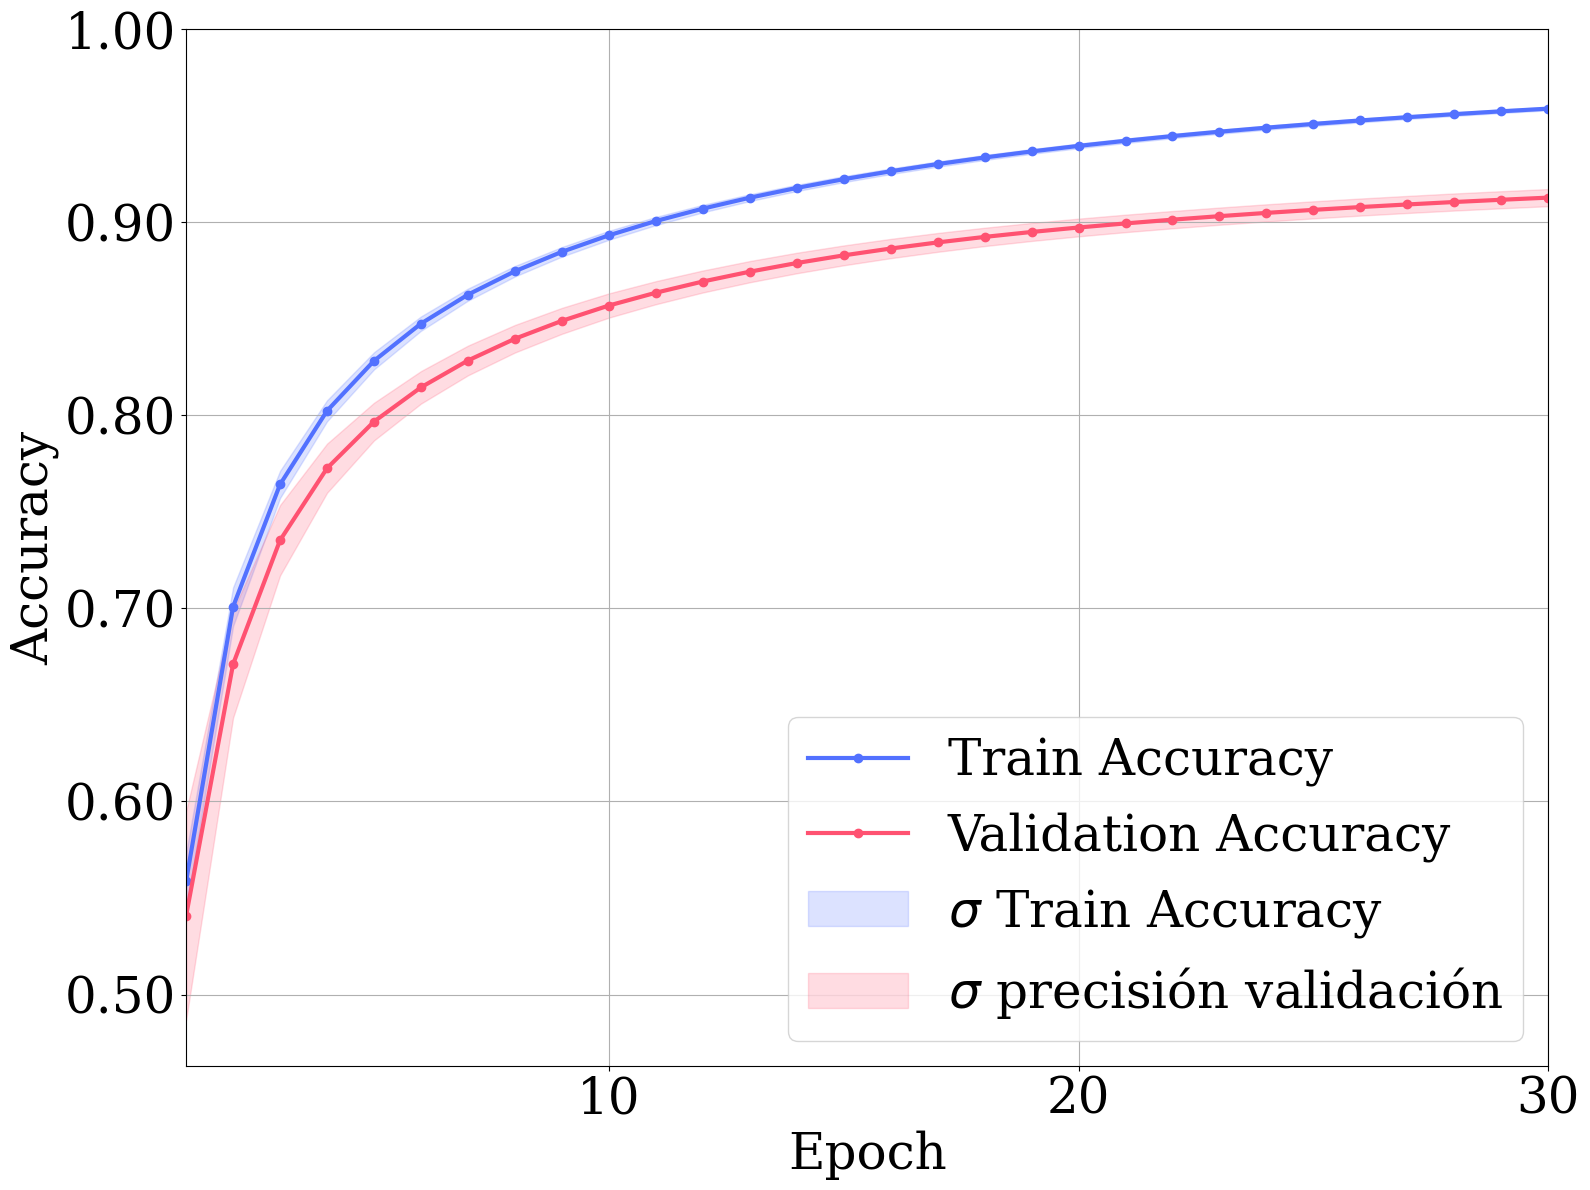

In [ ]:
# Gráfica de precisión

fig = plt.figure(figsize=(16, 12))
ax = plt.gca()
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.plot(range(1, epochs+1), train_acc_mean, '#5271ff', linestyle = "-", marker = "o",
          label='Train Accuracy', lw = 3)
plt.plot(range(1, epochs+1), val_acc_mean,  '#ff5271',
          label='Validation Accuracy', linestyle = '-', marker = 'o', lw = 3)
plt.fill_between(range(1, epochs+1),
                 train_acc_mean - train_acc_std,
                 train_acc_mean + train_acc_std,
                 label = r'$\sigma$ Train Accuracy',
                 alpha=0.2, color = '#5271ff')

plt.fill_between(range(1, epochs+1),
                 val_acc_mean - val_acc_std,
                 val_acc_mean + val_acc_std,
                 label = r'$\sigma$ precisión validación',
                 alpha=0.2, color = '#ff5271')
plt.xlabel('Epoch',fontsize=36)
plt.ylabel(r'Accuracy',fontsize=36)
plt.xlim([1, epochs])
plt.ylim(top=1)
plt.grid()
plt.legend(fontsize=36,loc = 'lower right')
plt.xticks(np.arange(10, epochs+1, step=10), fontsize=36)
plt.yticks(fontsize=36)
plt.tight_layout()
nameFile = 'presicionModelo4Capas-RegularizacionBN' +'.pdf'
plt.tight_layout()
plt.savefig(nameFile)